<a href="https://colab.research.google.com/github/DeepaliSinghTomar/100_Days_Of_ML/blob/master/BCG_CustomerChurnPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from datetime import datetime
# For Modeling
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# Shows plots in jupyter notebook
%matplotlib inline
# Set plot style
sns.set(color_codes=True)
# To avoid warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [80]:
client_df = pd.read_csv('CustomerChurn/client_data.csv')
price_df = pd.read_csv('CustomerChurn/price_data.csv')

In [81]:
client_df.head()
price_df.head(3)
client_df.info()
price_df.info()
client_df.describe()
price_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

price_off_peak_var  price_peak_var  price_mid_peak_var  \
count       193002.000000   193002.000000       193002.000000   
mean             0.141027        0.054630            0.030496   
std              0.025032        0.049924            0.036298   
min              0.000000        0.000000            0.000000   
25%              0.125976        0.000000            0.000000   
50%              0.146033        0.085483            0.000000   
75%              0.151635        0.101673            0.072558   
max              0.280700        0.229788            0.114102   

       price_off_peak_fix  price_peak_fix  price_mid_peak_fix  
count       193002.000000   193002.000000       193002.000000  
mean            43.334477       10.622875            6.409984  
std              5.410297       12.841895            7.773592  
min              0.000000        0.000000            0.000000  
25%             40.728885        0.000000            0.000000  
50%             44.266930        0.000000            0.000000  
75%             44.444710       24.339581           16.226389  
max             59.444710       36.490692           17.458221

In [82]:
def plot_stacked_bars(dataframe, title_, size_=(18, 10), rot_=0, legend_=None, legend_labels=None):
    """
    Plot stacked bars from a DataFrame.

    Parameters:
    - dataframe: DataFrame containing data for plotting.
    - title_: Title of the plot.
    - size_: Size of the plot (default is (18, 10)).
    - rot_: Rotation angle for x-axis labels (default is 0).
    - legend_: Location of the legend (default is None).
    - legend_labels: List of labels for the legend (default is None, will use DataFrame columns).

    Returns:
    None, displays the plot.
    """
    # Define colors based on categories (0 -> No, 1 -> Yes, third color if needed)
    colors = ['#01cdfe' , '#ff71ce', '#05ffa1']

    # Plot the stacked bars with the specified colors
    ax = dataframe.plot(
        kind="bar",
        stacked=True,
        figsize=size_,
        rot=rot_,
        title=title_,
        color=colors[:len(dataframe.columns)]  # Ensure we only use the required number of colors
    )
    # Annotate bars
    annotate_stacked_bars(ax, textsize=14)

    # Set legend with dynamic labels if provided
    if legend_labels:
        plt.legend(legend_labels, loc=legend_)
    elif legend_:
        plt.legend(loc=legend_)

    # Labels
    plt.ylabel("Company base (%)")
    plt.show()

In [83]:
def annotate_stacked_bars(ax, pad=0.99, textsize=13, show_zero=False, offset_x=-0.05, offset_y=0):
    """
    Annotate stacked bars on the plot.

    Parameters:
    - ax: Axes object for the plot.
    - pad: Padding for annotation position (default is 0.99).
    - textsize: Font size for annotation text (default is 13).
    - show_zero: Whether to show '0' as an annotation for zero-height bars (default is False).
    - offset_x: Horizontal offset for annotation (default is -0.05).
    - offset_y: Vertical offset for annotation (default is 0).

    Returns:
    None, annotates the bars on the plot.
    """
    # Define colors for text annotations based on bar color
    colors = ['#01cdfe' , '#ff71ce', '#05ffa1']

    # Iterate over the plotted rectangles/bars
    for p in ax.patches:
        value = round(p.get_height(), 1)

        # Skip zero-height bars unless show_zero is True
        if value == 0 and not show_zero:
            continue

        # Determine the color of the text based on the bar color
        bar_color = p.get_facecolor()
        text_color = 'black' if bar_color == (1.0, 1.0, 1.0, 1.0) else 'white'  # Default to black if the bar is white

        # Annotate the bar with the calculated text color
        ax.annotate(
            str(value),
            ((p.get_x() + p.get_width() / 2) * pad + offset_x, (p.get_y() + p.get_height() / 2) * pad + offset_y),
            color=text_color,
            size=textsize,
            ha='center', va='center'  # Center alignment for better readability
        )

In [84]:
churn = client_df[['id', 'churn']]
churn.columns = ['Companies', 'churn']
churn_total = churn.groupby(churn['churn']).count()
churn_percentage = churn_total / churn_total.sum() * 100

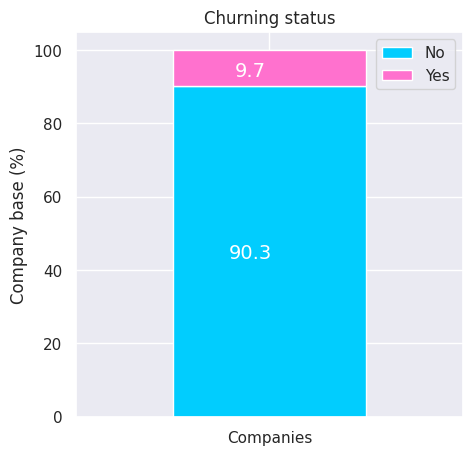

In [85]:
plot_stacked_bars(
    churn_percentage.transpose(),
    "Churning status",
    (5, 5),
    legend_labels=["No", "Yes"]
)

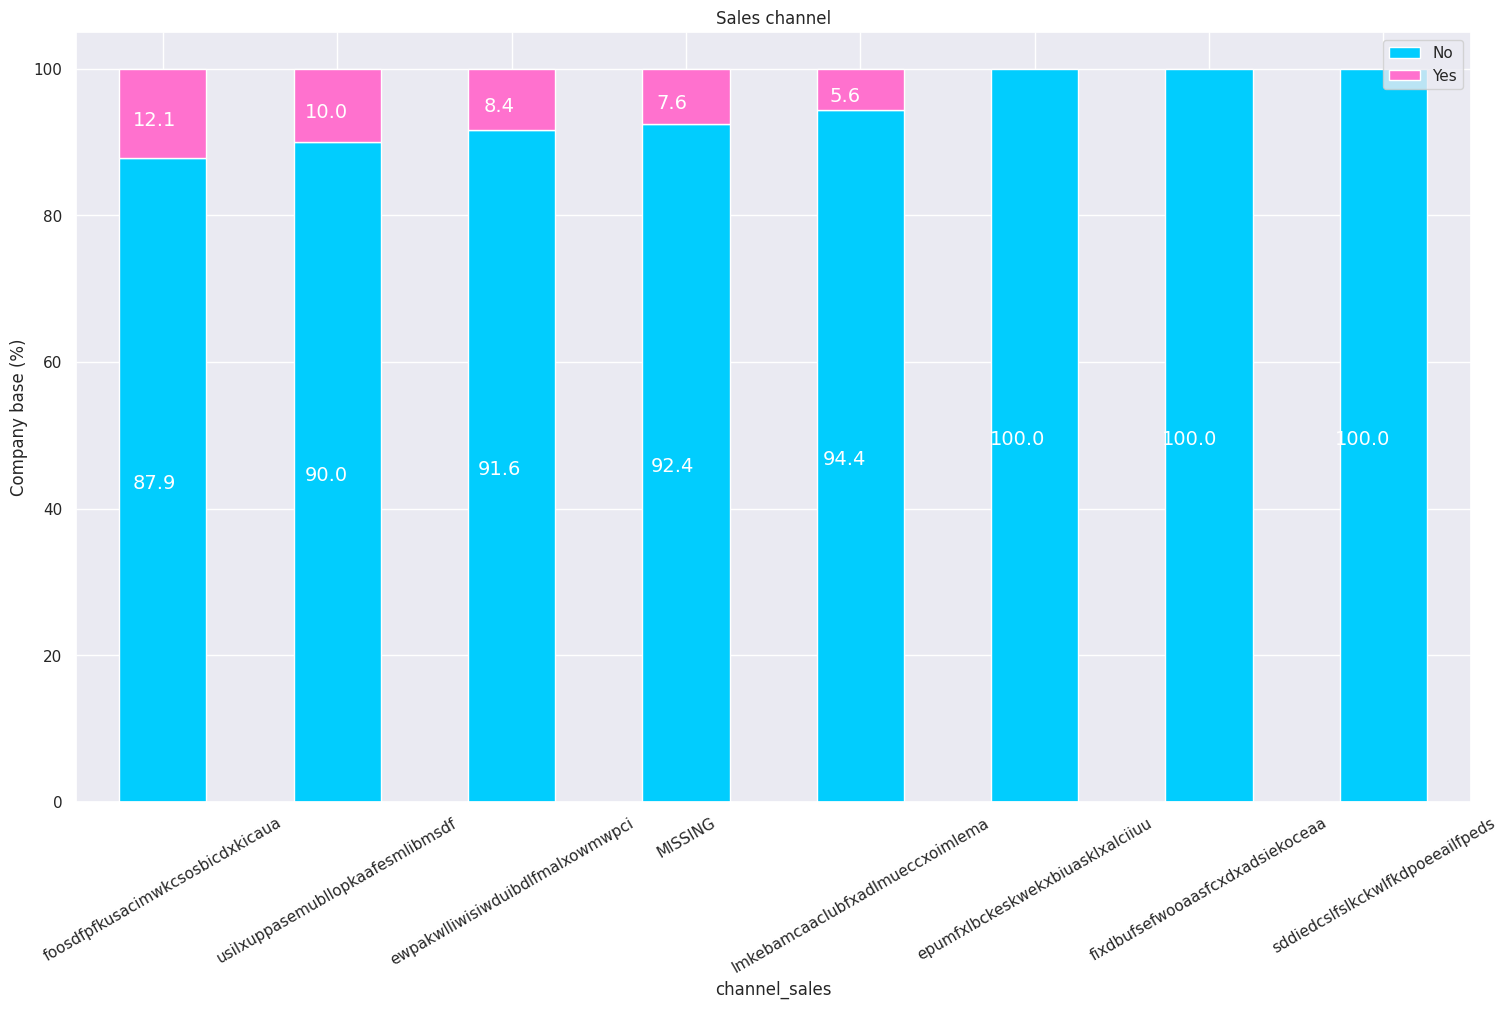

In [86]:
# Analyzing churn rates based on 'channel_sales' values, including 'MISSING'
channel = client_df[['id', 'channel_sales', 'churn']].copy()  # Make a copy of the DataFrame

# Handle 'MISSING' in 'channel_sales' by replacing NaN or unknown entries with a category 'MISSING'
channel['channel_sales'].fillna('MISSING', inplace=True)

# Group by 'channel_sales' and 'churn' and calculate churn rate
channel = channel.groupby(['channel_sales', 'churn'])['id'].count().unstack(level=1).fillna(0)

# Calculate churn percentages per channel
channel_churn = (channel.div(channel.sum(axis=1), axis=0) * 100).sort_values(by=[1], ascending=False)

# Plotting stacked bars for churn percentage by sales channel
plot_stacked_bars(channel_churn, 'Sales channel', rot_=30, legend_="upper right", legend_labels=["No", "Yes"])

In [87]:
# Analyzing churn rates based on 'channel_sales' values, including 'MISSING'
channel = client_df[['id', 'channel_sales', 'churn']].copy()  # Make a copy of the DataFrame

# Handle 'MISSING' in 'channel_sales' by replacing NaN or unknown entries with a category 'MISSING'
channel['channel_sales'].fillna('MISSING', inplace=True)

# Group by 'channel_sales' and 'churn' and calculate churn rate
channel_grouped = channel.groupby(['channel_sales', 'churn'])['id'].count().unstack(level=1).fillna(0)

# Calculate churn percentages per channel
channel_churn = (channel_grouped.div(channel_grouped.sum(axis=1), axis=0) * 100).sort_values(by=[1], ascending=False)

# Print churn percentages for each channel
print("Churn percentages by channel sales:")
print(channel_churn)

Churn percentages by channel sales:
churn                                      0          1
channel_sales                                          
foosdfpfkusacimwkcsosbicdxkicaua   87.859046  12.140954
usilxuppasemubllopkaafesmlibmsdf   89.963636  10.036364
ewpakwlliwisiwduibdlfmalxowmwpci   91.601344   8.398656
MISSING                            92.402685   7.597315
lmkebamcaaclubfxadlmueccxoimlema   94.411286   5.588714
epumfxlbckeskwekxbiuasklxalciiuu  100.000000   0.000000
fixdbufsefwooaasfcxdxadsiekoceaa  100.000000   0.000000
sddiedcslfslkckwlfkdpoeeailfpeds  100.000000   0.000000


In [88]:
consumption = client_df[['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month', 'imp_cons', 'has_gas', 'churn']]

In [89]:
def plot_distribution(dataframe, column, ax, bins_=50):
    """
    Plot variable distribution in a stacked histogram of churned or retained companies.

    Parameters:
    - dataframe: DataFrame containing the data.
    - column: The column name for which the distribution is plotted.
    - ax: The axis object for the plot.
    - bins_: Number of bins for the histogram (default is 50).
    """
    # Create a temporary dataframe for Retention and Churn based on 'churn' column
    temp = pd.DataFrame({
        "Retention": dataframe[dataframe["churn"] == 0][column],
        "Churn": dataframe[dataframe["churn"] == 1][column]
    })

    # Plot the histogram with custom colors for Retention and Churn
    temp[["Retention", "Churn"]].plot(kind='hist', bins=bins_, ax=ax, stacked=True, color=['#01cdfe', '#ff71ce'])

    # X-axis label
    ax.set_xlabel(column)

    # Set x-axis to plain style for better readability
    ax.ticklabel_format(style='plain', axis='x')

    # Add a title for the plot
    ax.set_title(f"Distribution of {column} by Churn Status")

    # Add custom legend labels
    ax.legend(["No", "Yes"], loc="upper right")

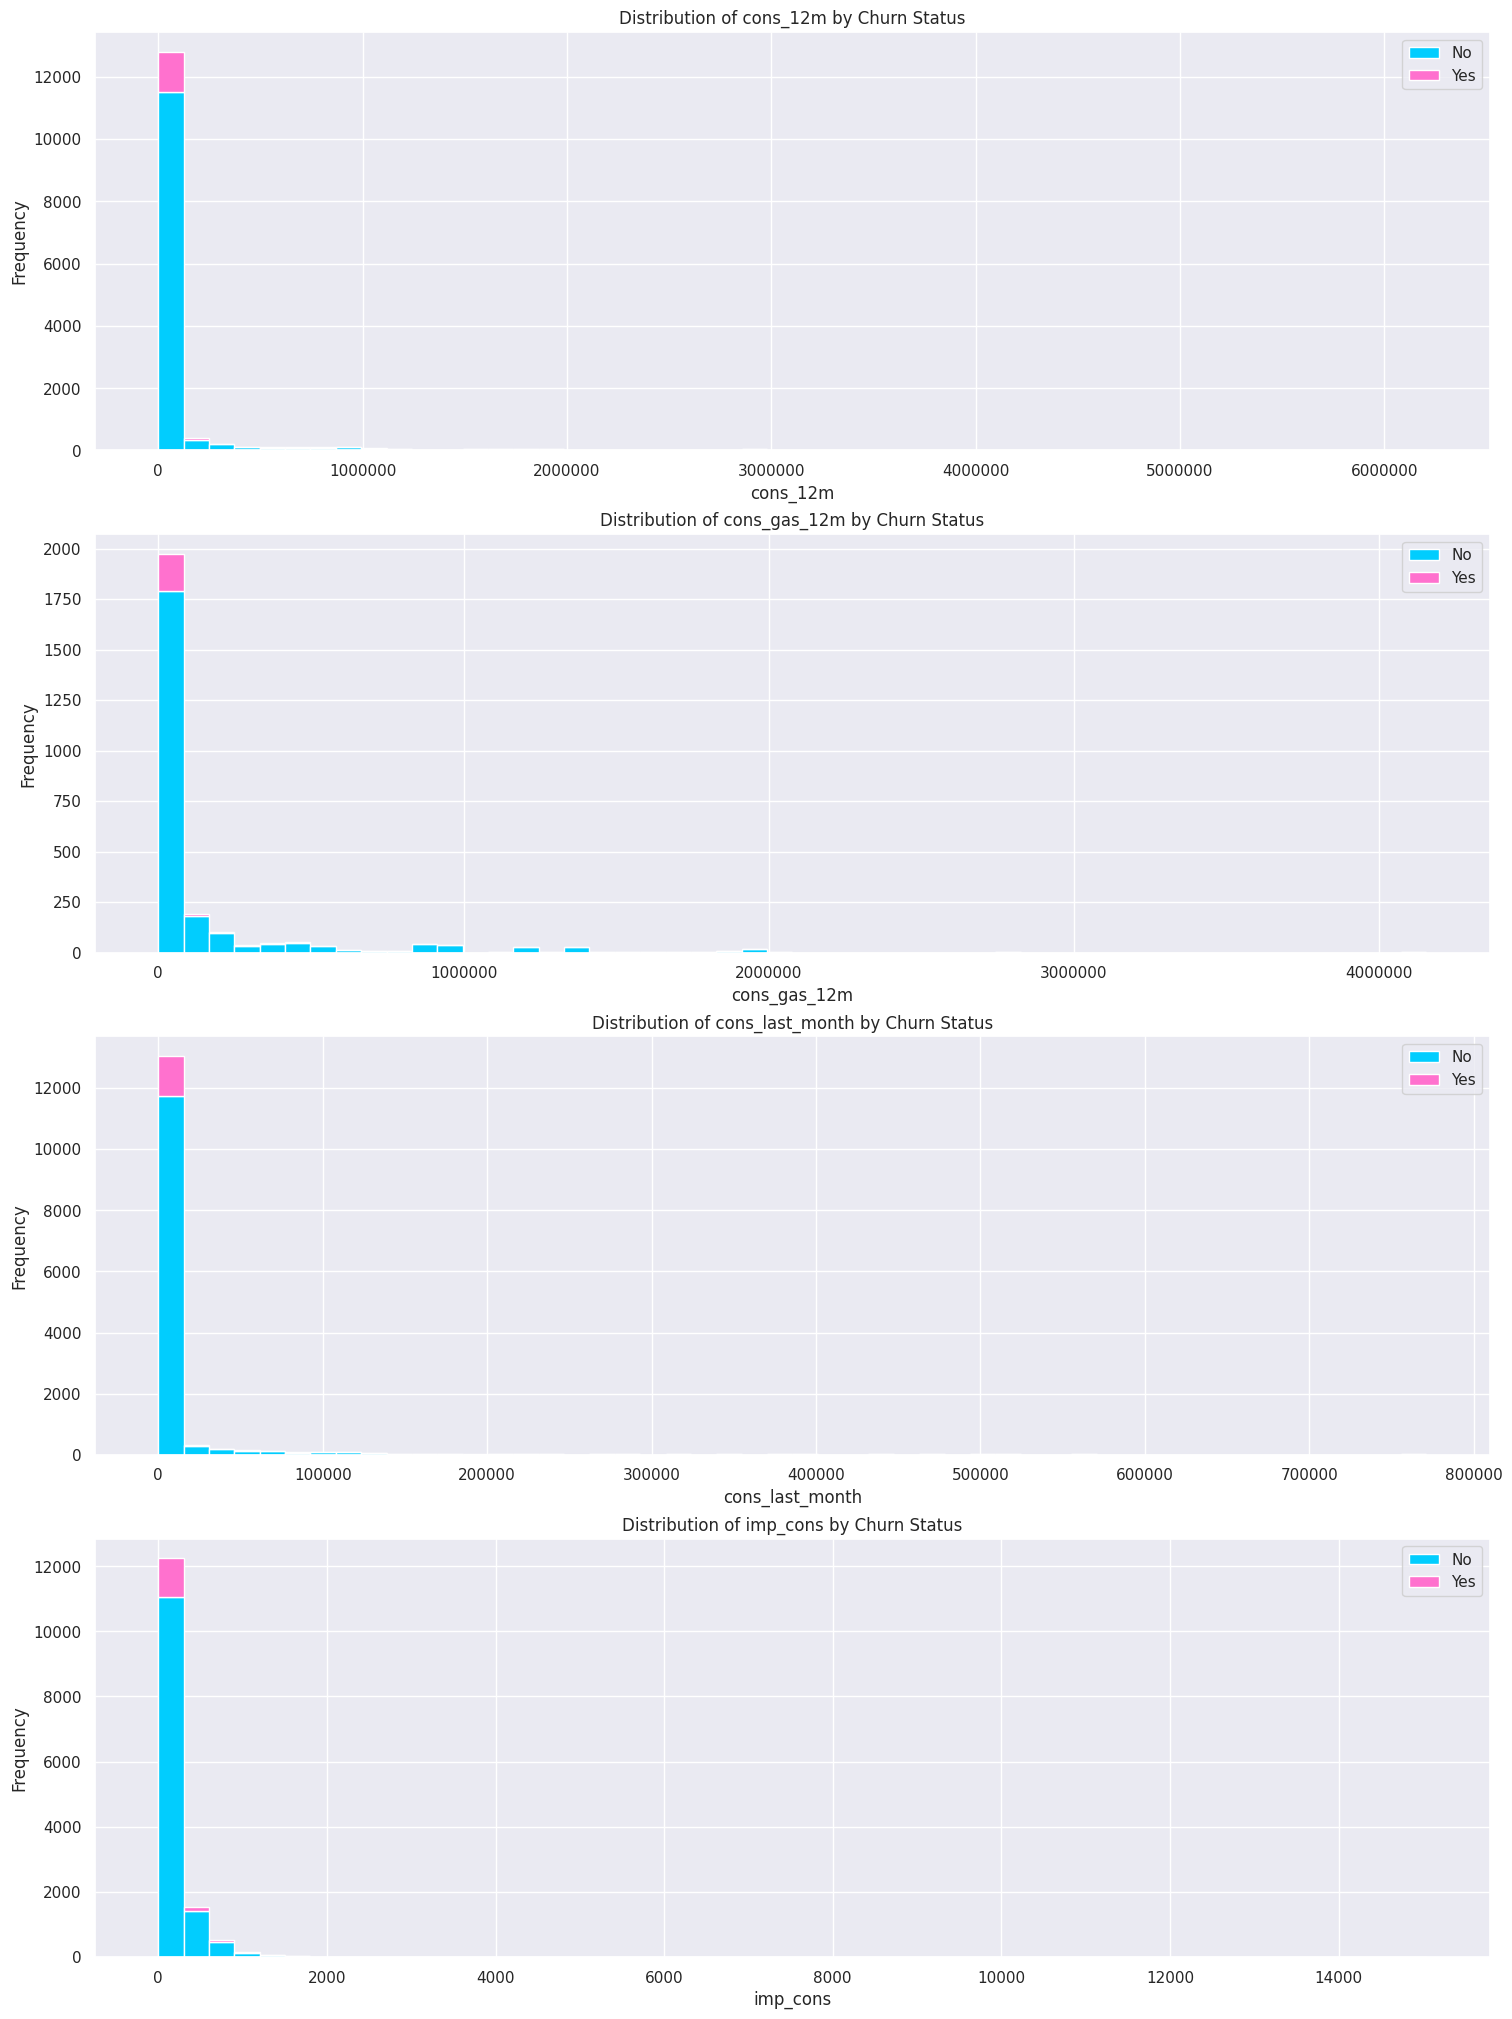

In [90]:
fig, axs = plt.subplots(nrows=4, figsize=(18, 25))

plot_distribution(consumption, 'cons_12m', axs[0])
plot_distribution(consumption[consumption['has_gas'] == 't'], 'cons_gas_12m', axs[1])
plot_distribution(consumption, 'cons_last_month', axs[2])
plot_distribution(consumption, 'imp_cons', axs[3])

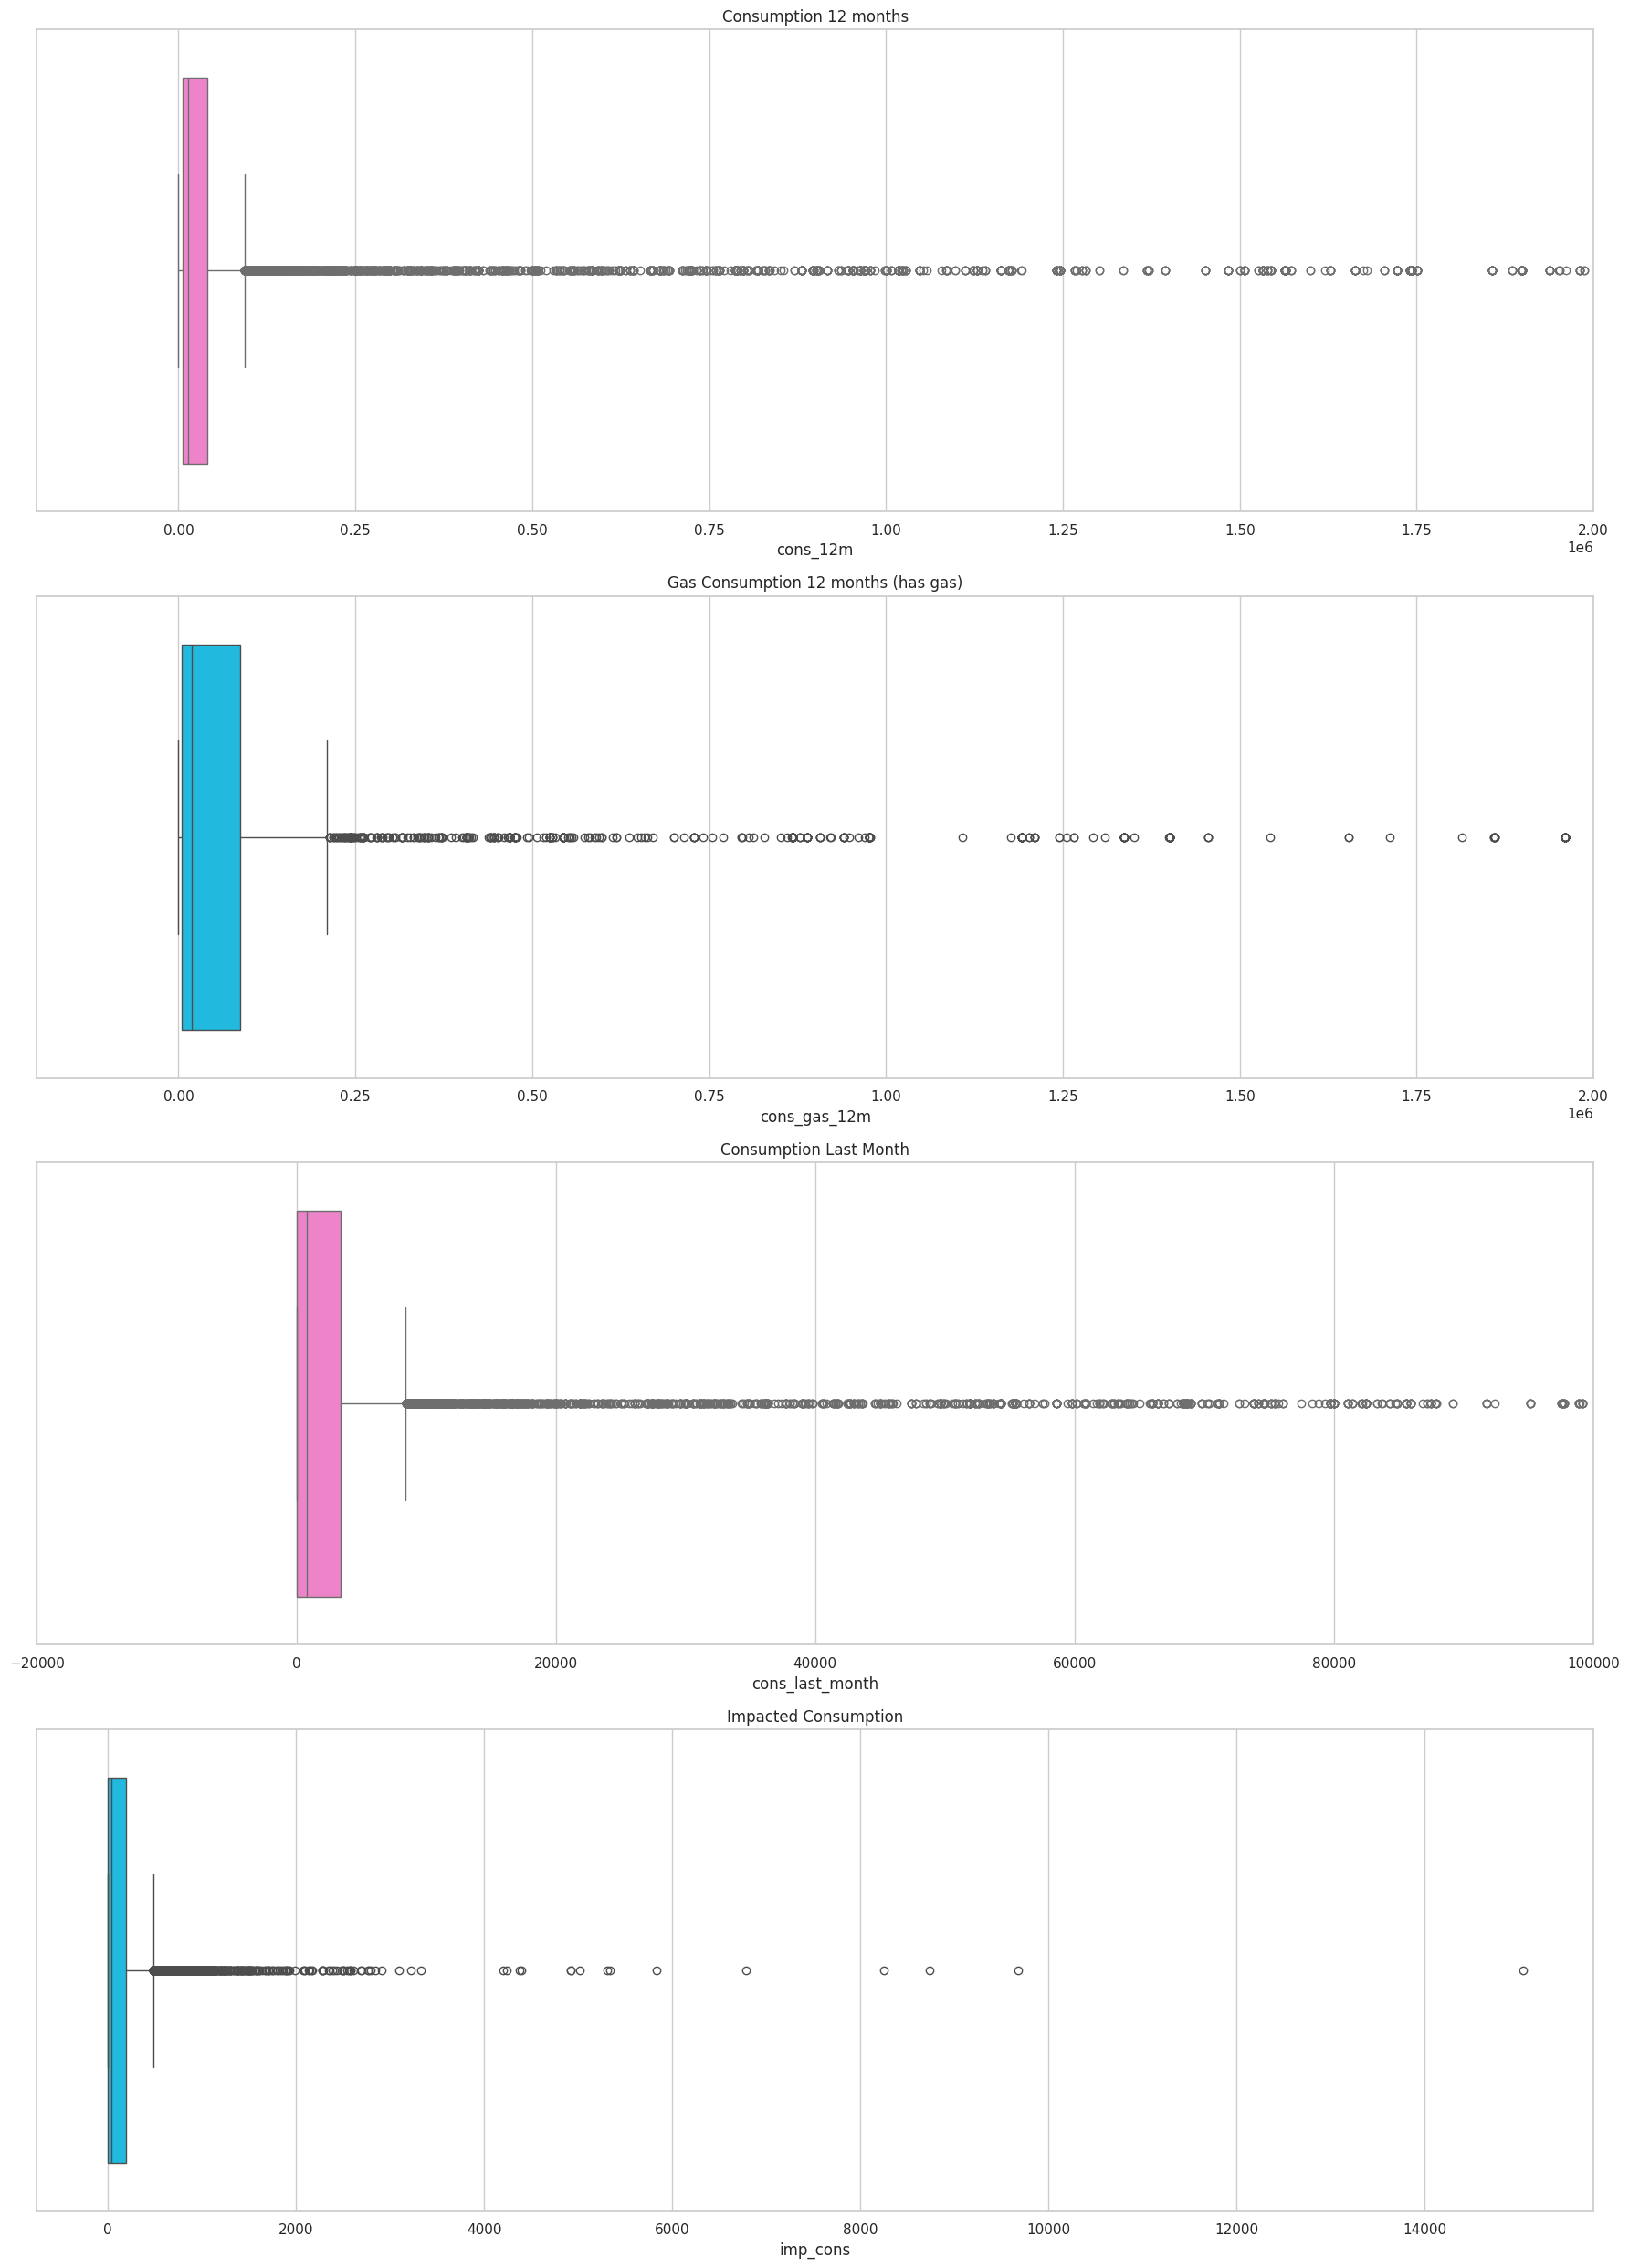

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Set seaborn style
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axs = plt.subplots(nrows=4, figsize=(18, 25))

# Plot boxplots using seaborn
sns.boxplot(x=consumption["cons_12m"], ax=axs[0], color='#ff71ce')  # Retention color
sns.boxplot(x=consumption[consumption["has_gas"] == "t"]["cons_gas_12m"], ax=axs[1], color='#01cdfe')  # Churn color
sns.boxplot(x=consumption["cons_last_month"], ax=axs[2], color='#ff71ce')  # Retention color
sns.boxplot(x=consumption["imp_cons"], ax=axs[3], color='#01cdfe')  # Churn color

# Remove scientific notation for x-axis
for ax in axs:
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))

# Set specific x-axis limits
axs[0].set_xlim(-200000, 2000000)
axs[1].set_xlim(-200000, 2000000)
axs[2].set_xlim(-20000, 100000)

# Add titles for each subplot
axs[0].set_title("Consumption 12 months")
axs[1].set_title("Gas Consumption 12 months (has gas)")
axs[2].set_title("Consumption Last Month")
axs[3].set_title("Impacted Consumption")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [92]:
def plot_distribution(dataframe, column, ax, bins_=50):
    """
    Plot variable distribution in a stacked histogram of churned or retained company using seaborn.

    Parameters:
    - dataframe: DataFrame containing the data.
    - column: The column name for which the distribution is plotted.
    - ax: The axis object for the plot.
    - bins_: Number of bins for the histogram (default is 50).
    """
    # Create a temporary dataframe for Retention and Churn based on 'churn' column
    temp = pd.DataFrame({
        "Retention": dataframe[dataframe["churn"] == 0][column],
        "Churn": dataframe[dataframe["churn"] == 1][column]
    })

    # Plot the histogram with custom colors for Retention and Churn using Seaborn
    temp[["Retention", "Churn"]].plot(kind='hist', bins=bins_, ax=ax, stacked=True, color=['#ff71ce', '#01cdfe'], alpha=0.7)

    # Set the x-axis label
    ax.set_xlabel(column)

    # Set title
    ax.set_title(f"Distribution of {column} by Churn Status")

    # Set x-axis to plain style
    ax.ticklabel_format(style='plain', axis='x')

    # Add custom legend
    ax.legend(["No", "Yes"], loc="upper right")

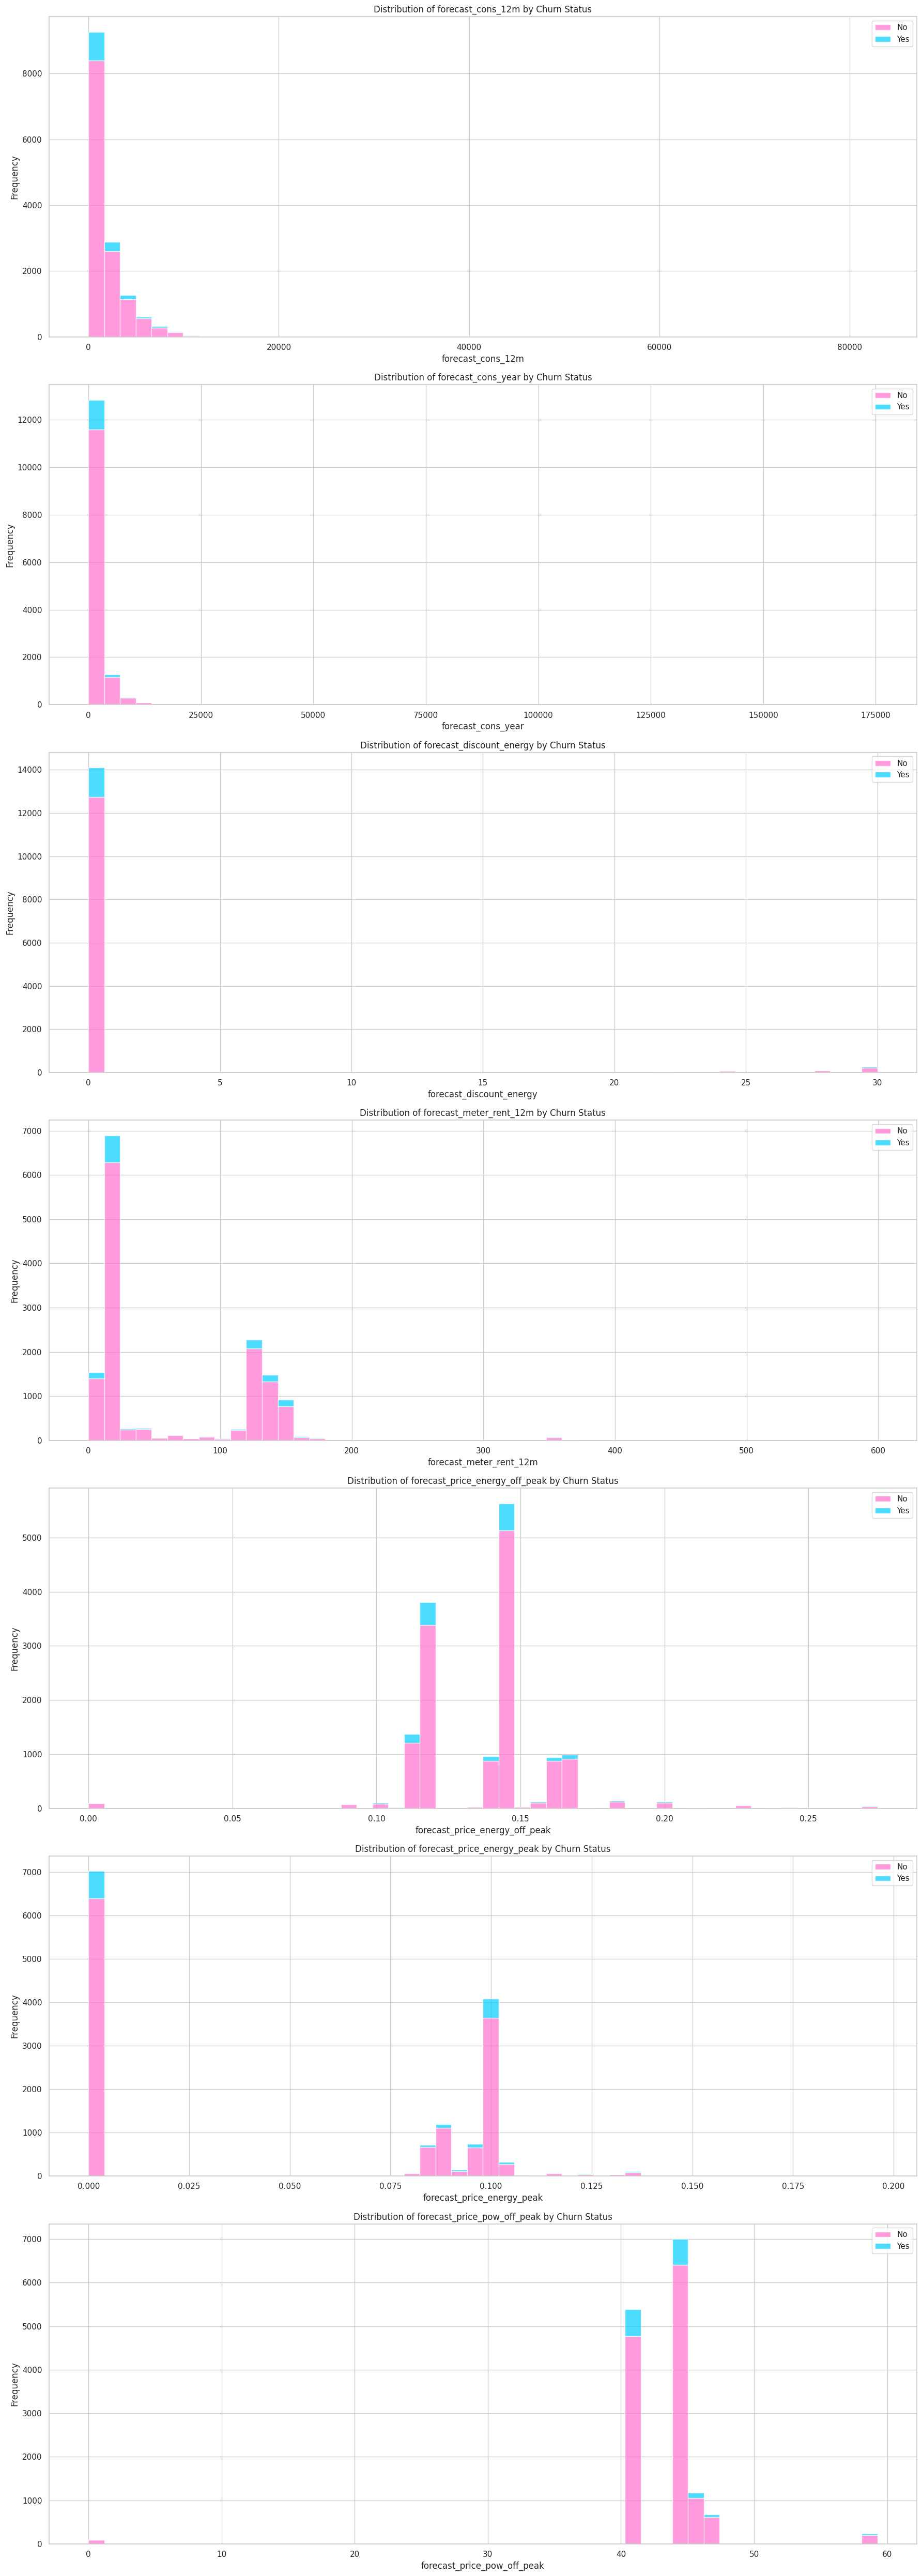

In [93]:
# Forecast DataFrame
forecast = client_df[[
    "id", "forecast_cons_12m", "forecast_cons_year", "forecast_discount_energy",
    "forecast_meter_rent_12m", "forecast_price_energy_off_peak", "forecast_price_energy_peak",
    "forecast_price_pow_off_peak", "churn"
]]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=7, figsize=(18, 50))

# Plot the distributions using the modified `plot_distribution` function
plot_distribution(forecast, "forecast_cons_12m", axs[0])
plot_distribution(forecast, "forecast_cons_year", axs[1])
plot_distribution(forecast, "forecast_discount_energy", axs[2])
plot_distribution(forecast, "forecast_meter_rent_12m", axs[3])
plot_distribution(forecast, "forecast_price_energy_off_peak", axs[4])
plot_distribution(forecast, "forecast_price_energy_peak", axs[5])
plot_distribution(forecast, "forecast_price_pow_off_peak", axs[6])

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

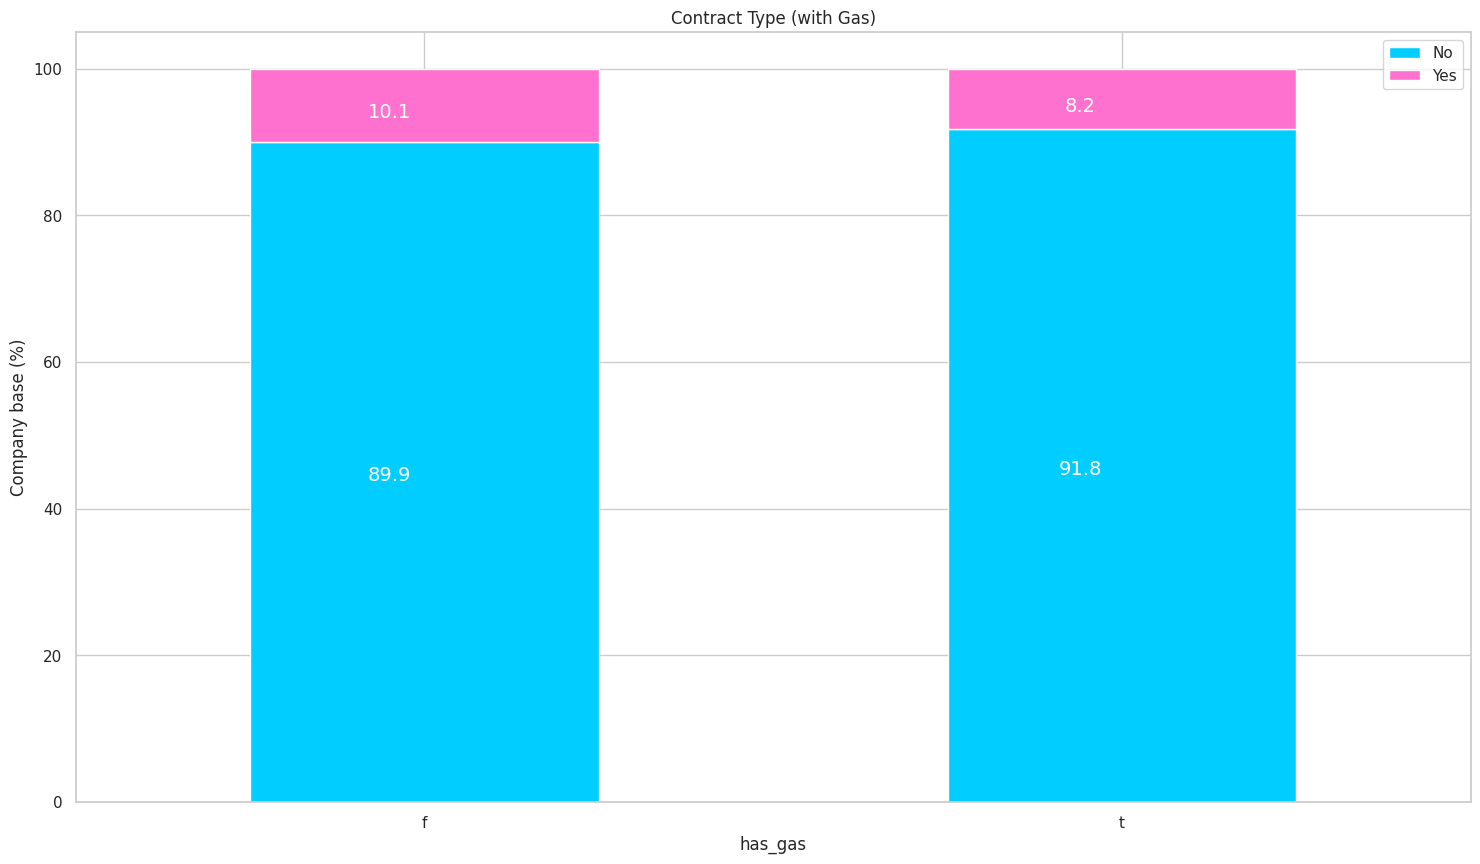

In [94]:
# Group by 'churn' and 'has_gas', then calculate percentage
contract_type = client_df[['id', 'has_gas', 'churn']]
contract = contract_type.groupby([contract_type['churn'], contract_type['has_gas']])['id'].count().unstack(level=0)
contract_percentage = (contract.div(contract.sum(axis=1), axis=0) * 100).sort_values(by=[1], ascending=False)

# Plotting stacked bars for contract type percentage
plot_stacked_bars(contract_percentage, 'Contract Type (with Gas)', rot_=0, legend_labels=["No", "Yes"])

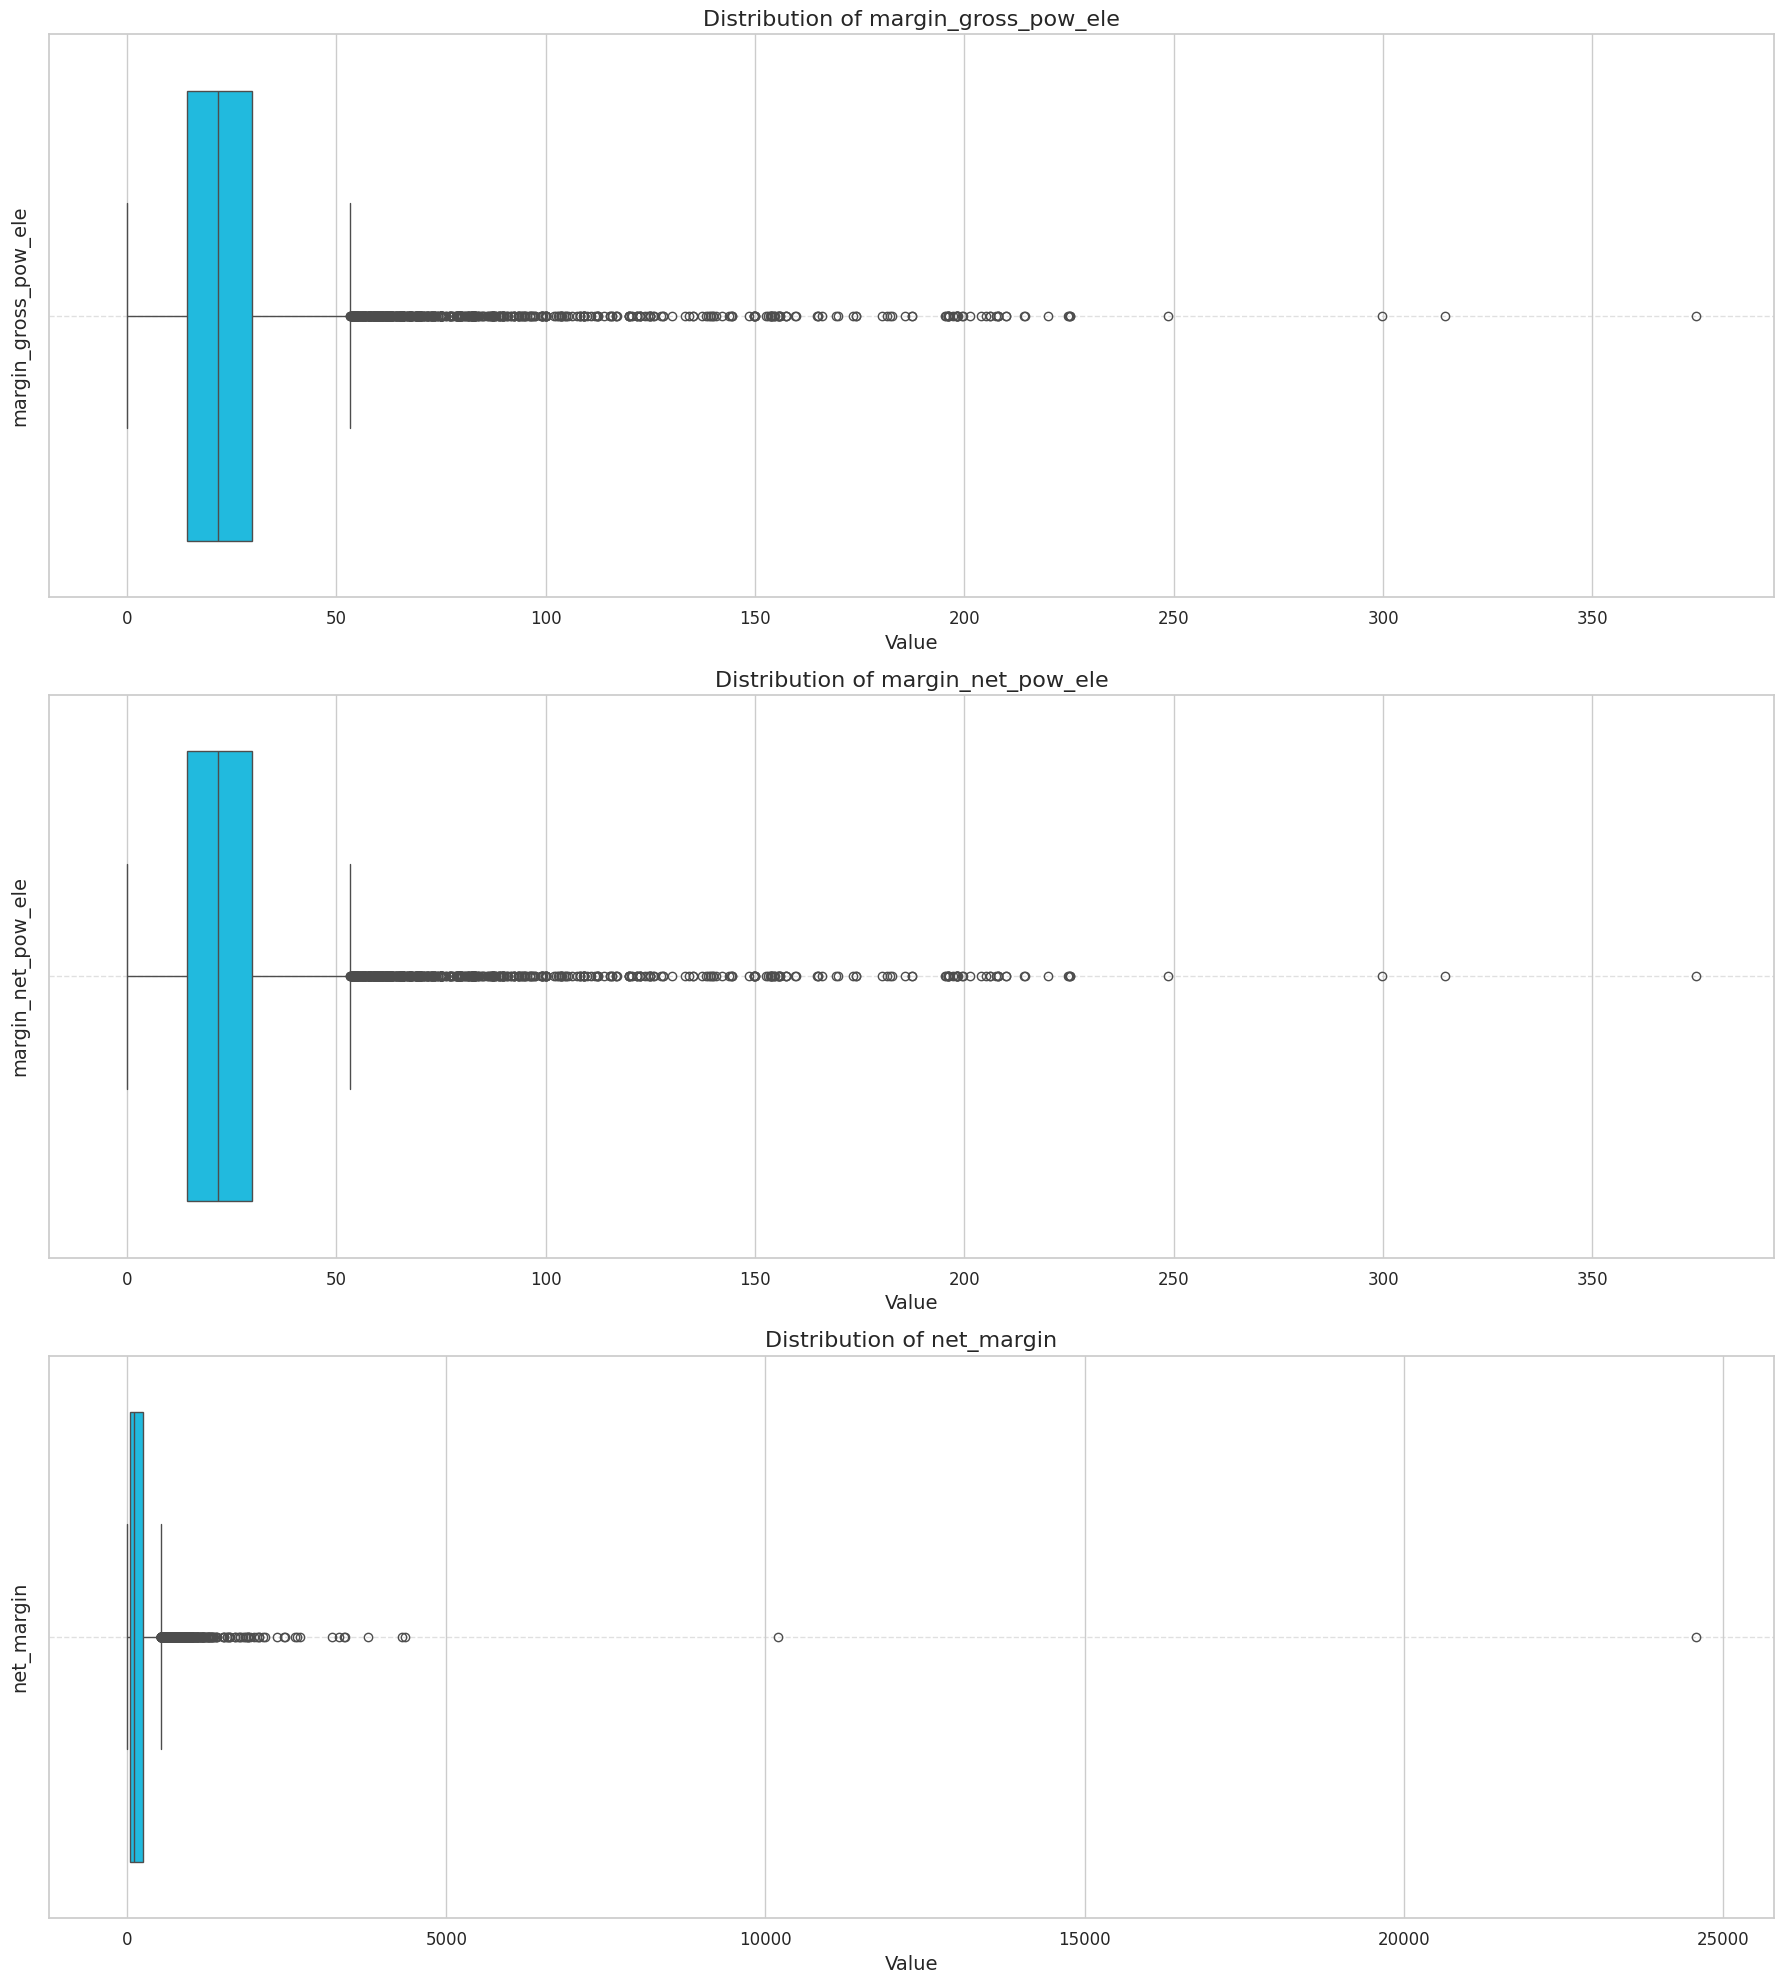

In [95]:
# Set seaborn style for cleaner visuals
sns.set(style="whitegrid")

# Assuming 'margin' data is in 'client_df', create the DataFrame
margin = client_df[["margin_gross_pow_ele", "margin_net_pow_ele", "net_margin"]]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))

# Define the color for all the boxplots
boxplot_color = '#01cdfe'  # Churn color

# Plot boxplots with the same color for each column in margin
sns.boxplot(x=margin["margin_gross_pow_ele"], ax=axs[0], color=boxplot_color)
sns.boxplot(x=margin["margin_net_pow_ele"], ax=axs[1], color=boxplot_color)
sns.boxplot(x=margin["net_margin"], ax=axs[2], color=boxplot_color)

# Customize axes and layout for better readability
for i, ax in enumerate(axs):
    # Remove scientific notation for x-axis
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))

    # Set titles for each subplot
    ax.set_title(f"Distribution of {margin.columns[i]}", fontsize=16)

    # Set x-axis and y-axis labels
    ax.set_xlabel('Value', fontsize=14)
    ax.set_ylabel(margin.columns[i], fontsize=14)

    # Customize tick labels for readability
    ax.tick_params(axis='both', labelsize=12)

    # Add horizontal gridlines
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

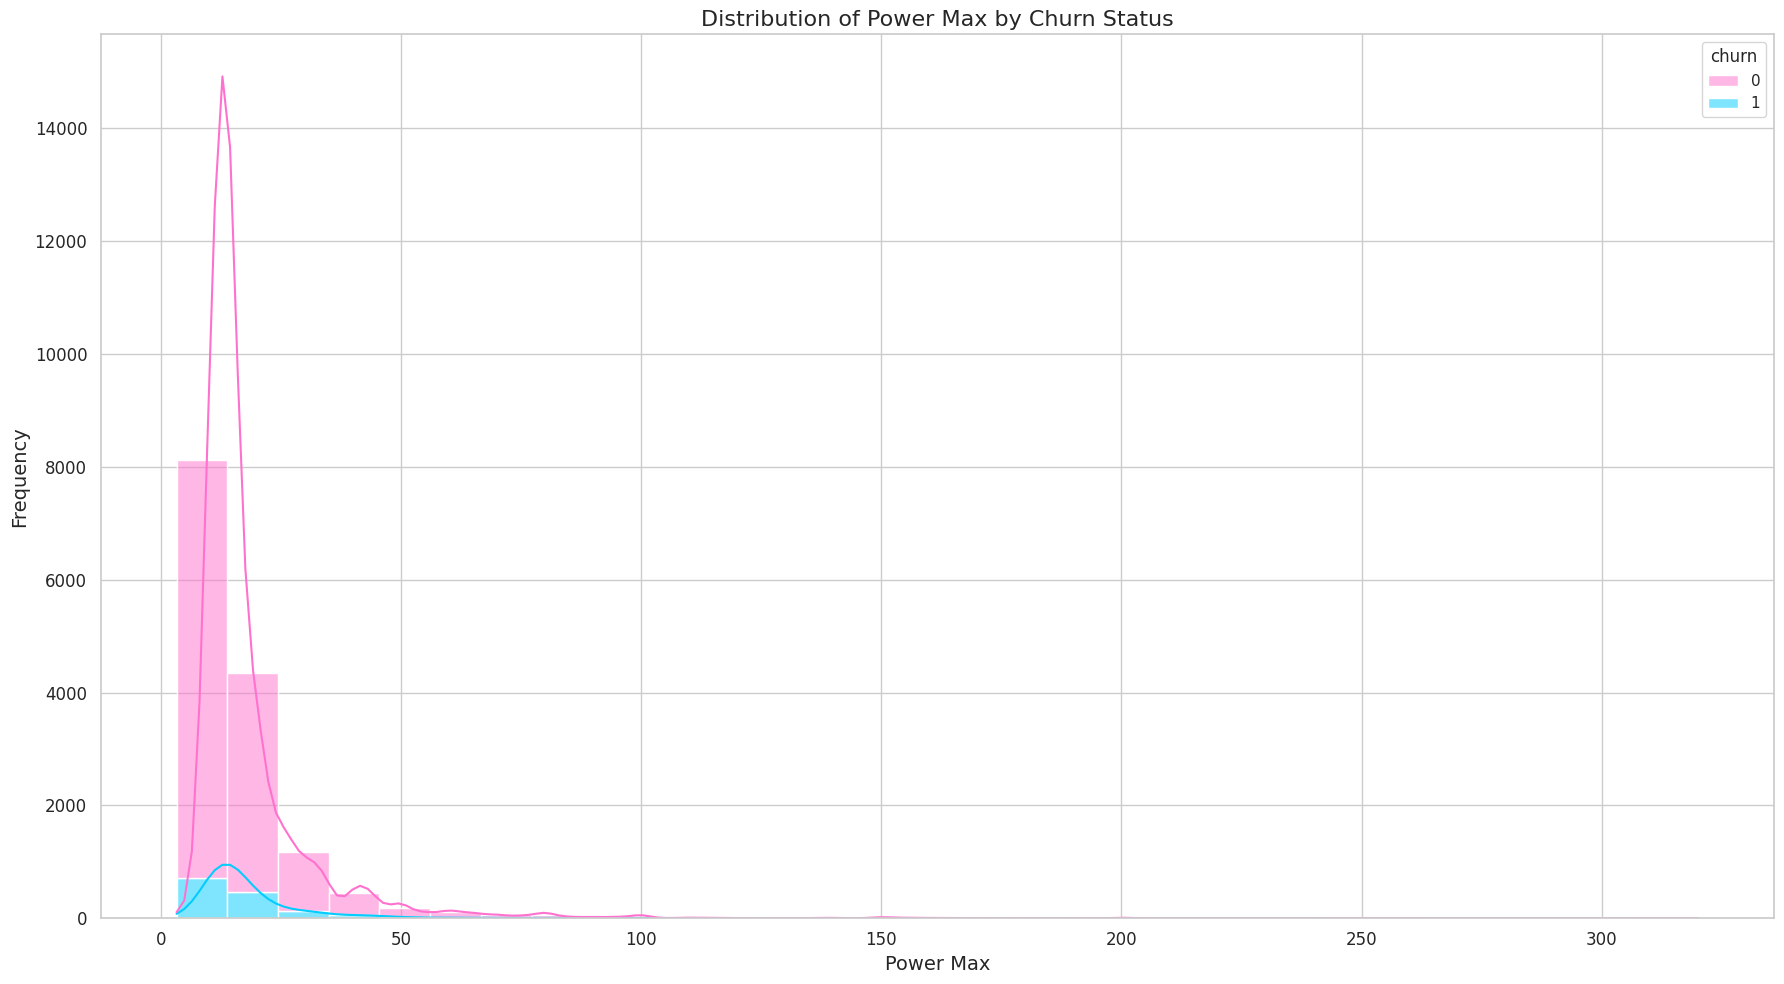

In [96]:
# Set seaborn style for cleaner visuals
sns.set(style="whitegrid")

# Define the custom colors for retention and churn
colors = ['#ff71ce', '#01cdfe']  # Retention (No) and Churn (Yes)

# Create a figure for the distribution plot
fig, axs = plt.subplots(nrows=1, figsize=(18, 10))

# Assuming 'power' data is within 'client_df', extract the relevant columns
power = client_df[['pow_max', 'churn']]  # Replace 'pow_max' with the actual column name if different

# Plot the distribution of 'pow_max' based on 'churn' (0 for retention, 1 for churn)
sns.histplot(data=power, x='pow_max', hue='churn', multiple="stack", bins=30, ax=axs, palette=colors, kde=True)

# Set the title and labels
axs.set_title('Distribution of Power Max by Churn Status', fontsize=16)
axs.set_xlabel('Power Max', fontsize=14)
axs.set_ylabel('Frequency', fontsize=14)

# Customize tick labels
axs.tick_params(axis='both', labelsize=12)

# Show the plot
plt.tight_layout()
plt.show()

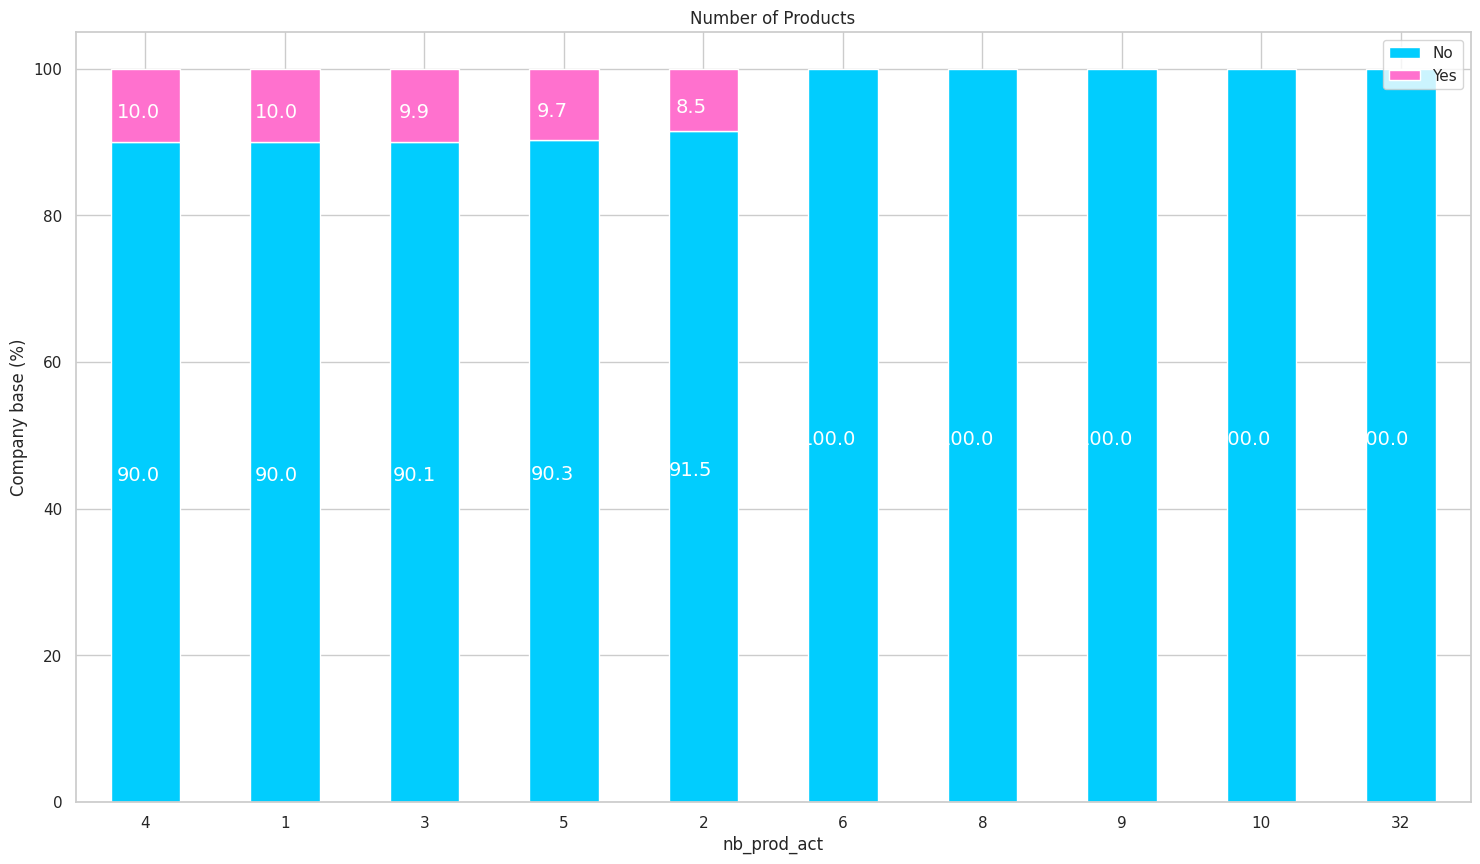

In [97]:
# Grouping by 'nb_prod_act' and 'churn' and calculating percentages
others = client_df[['id', 'nb_prod_act', 'churn']]
products = others.groupby([others["nb_prod_act"], others["churn"]])["id"].count().unstack(level=1)
products_percentage = (products.div(products.sum(axis=1), axis=0) * 100).sort_values(by=[1], ascending=False)


# Plotting stacked bars for the number of products with churn percentages
plot_stacked_bars(products_percentage, "Number of Products", size_=(18, 10), legend_labels=["No", "Yes"], legend_="upper right")

In [98]:
# Transform date columns to datetime type
client_df["date_activ"] = pd.to_datetime(client_df["date_activ"], format='%Y-%m-%d')
client_df["date_end"] = pd.to_datetime(client_df["date_end"], format='%Y-%m-%d')
client_df["date_modif_prod"] = pd.to_datetime(client_df["date_modif_prod"], format='%Y-%m-%d')
client_df["date_renewal"] = pd.to_datetime(client_df["date_renewal"], format='%Y-%m-%d')
price_df['price_date'] = pd.to_datetime(price_df['price_date'], format='%Y-%m-%d')

# Create mean average data
mean_year = price_df.groupby(['id']).mean().reset_index()
mean_6m = price_df[price_df['price_date'] > '2015-06-01'].groupby(['id']).mean().reset_index()
mean_3m = price_df[price_df['price_date'] > '2015-10-01'].groupby(['id']).mean().reset_index()

# Combine into single dataframe
mean_year = mean_year.rename(
    index=str,
    columns={
        "price_off_peak_var": "mean_year_price_off_peak_var",
        "price_peak_var": "mean_year_price_peak_var",
        "price_mid_peak_var": "mean_year_price_mid_peak_var",
        "price_off_peak_fix": "mean_year_price_off_peak_fix",
        "price_peak_fix": "mean_year_price_peak_fix",
        "price_mid_peak_fix": "mean_year_price_mid_peak_fix"
    }
)

mean_year["mean_year_price_off_peak"] = mean_year["mean_year_price_off_peak_var"] + mean_year["mean_year_price_off_peak_fix"]
mean_year["mean_year_price_peak"] = mean_year["mean_year_price_peak_var"] + mean_year["mean_year_price_peak_fix"]
mean_year["mean_year_price_mid_peak"] = mean_year["mean_year_price_mid_peak_var"] + mean_year["mean_year_price_mid_peak_fix"]


mean_6m = mean_6m.rename(
    index=str,
    columns={
        "price_off_peak_var": "mean_6m_price_off_peak_var",
        "price_peak_var": "mean_6m_price_peak_var",
        "price_mid_peak_var": "mean_6m_price_mid_peak_var",
        "price_off_peak_fix": "mean_6m_price_off_peak_fix",
        "price_peak_fix": "mean_6m_price_peak_fix",
        "price_mid_peak_fix": "mean_6m_price_mid_peak_fix"
    }
)
mean_6m["mean_6m_price_off_peak"] = mean_6m["mean_6m_price_off_peak_var"] + mean_6m["mean_6m_price_off_peak_fix"]
mean_6m["mean_6m_price_peak"] = mean_6m["mean_6m_price_peak_var"] + mean_6m["mean_6m_price_peak_fix"]
mean_6m["mean_6m_price_mid_peak"] = mean_6m["mean_6m_price_mid_peak_var"] + mean_6m["mean_6m_price_mid_peak_fix"]

mean_3m = mean_3m.rename(
    index=str,
    columns={
        "price_off_peak_var": "mean_3m_price_off_peak_var",
        "price_peak_var": "mean_3m_price_peak_var",
        "price_mid_peak_var": "mean_3m_price_mid_peak_var",
        "price_off_peak_fix": "mean_3m_price_off_peak_fix",
        "price_peak_fix": "mean_3m_price_peak_fix",
        "price_mid_peak_fix": "mean_3m_price_mid_peak_fix"
    }
)
mean_3m["mean_3m_price_off_peak"] = mean_3m["mean_3m_price_off_peak_var"] + mean_3m["mean_3m_price_off_peak_fix"]
mean_3m["mean_3m_price_peak"] = mean_3m["mean_3m_price_peak_var"] + mean_3m["mean_3m_price_peak_fix"]
mean_3m["mean_3m_price_mid_peak"] = mean_3m["mean_3m_price_mid_peak_var"] + mean_3m["mean_3m_price_mid_peak_fix"]

# Merge into 1 dataframe
price_features = pd.merge(mean_year, mean_6m, on='id')
price_features = pd.merge(price_features, mean_3m, on='id')

In [99]:
price_features.head()

id        price_date_x  \
0  0002203ffbb812588b632b9e628cc38d 2015-06-16 12:00:00   
1  0004351ebdd665e6ee664792efc4fd13 2015-06-16 12:00:00   
2  0010bcc39e42b3c2131ed2ce55246e3c 2015-06-16 12:00:00   
3  0010ee3855fdea87602a5b7aba8e42de 2015-06-16 12:00:00   
4  00114d74e963e47177db89bc70108537 2015-06-16 12:00:00   

   mean_year_price_off_peak_var  mean_year_price_peak_var  \
0                      0.124338                  0.103794   
1                      0.146426                  0.000000   
2                      0.181558                  0.000000   
3                      0.118757                  0.098292   
4                      0.147926                  0.000000   

   mean_year_price_mid_peak_var  mean_year_price_off_peak_fix  \
0                      0.073160                     40.701732   
1                      0.000000                     44.385450   
2                      0.000000                     45.319710   
3                      0.069032                     40.647427   
4                      0.000000                     44.266930   

   mean_year_price_peak_fix  mean_year_price_mid_peak_fix  \
0                 24.421038                     16.280694   
1                  0.000000                      0.000000   
2                  0.000000                      0.000000   
3                 24.388455                     16.258971   
4                  0.000000                      0.000000   

   mean_year_price_off_peak  mean_year_price_peak  ...  price_date  \
0                 40.826071             24.524832  ...  2015-11-16   
1                 44.531877              0.000000  ...  2015-11-16   
2                 45.501268              0.000000  ...  2015-11-16   
3                 40.766185             24.486748  ...  2015-11-16   
4                 44.414856              0.000000  ...  2015-11-16   

  mean_3m_price_off_peak_var  mean_3m_price_peak_var  \
0                   0.119906                0.101673   
1                   0.143943                0.000000   
2                   0.201280                0.000000   
3                   0.113068                0.095385   
4                   0.145440                0.000000   

   mean_3m_price_mid_peak_var  mean_3m_price_off_peak_fix  \
0                    0.073719                   40.728885   
1                    0.000000                   44.444710   
2                    0.000000                   45.944710   
3                    0.069409                   40.728885   
4                    0.000000                   44.266930   

   mean_3m_price_peak_fix  mean_3m_price_mid_peak_fix  mean_3m_price_off_peak  \
0                24.43733                   16.291555               40.848791   
1                 0.00000                    0.000000               44.588653   
2                 0.00000                    0.000000               46.145990   
3                24.43733                   16.291555               40.841953   
4                 0.00000                    0.000000               44.412370   

   mean_3m_price_peak  mean_3m_price_mid_peak  
0           24.539003               16.365274  
1            0.000000                0.000000  
2            0.000000                0.000000  
3           24.532715               16.360964  
4            0.000000                0.000000  

[5 rows x 31 columns]

In [100]:
price_analysis = pd.merge(price_features, client_df[['id', 'churn']], on='id')
price_analysis.head()

id        price_date_x  \
0  0002203ffbb812588b632b9e628cc38d 2015-06-16 12:00:00   
1  0004351ebdd665e6ee664792efc4fd13 2015-06-16 12:00:00   
2  0010bcc39e42b3c2131ed2ce55246e3c 2015-06-16 12:00:00   
3  00114d74e963e47177db89bc70108537 2015-06-16 12:00:00   
4  0013f326a839a2f6ad87a1859952d227 2015-06-16 12:00:00   

   mean_year_price_off_peak_var  mean_year_price_peak_var  \
0                      0.124338                  0.103794   
1                      0.146426                  0.000000   
2                      0.181558                  0.000000   
3                      0.147926                  0.000000   
4                      0.126076                  0.105542   

   mean_year_price_mid_peak_var  mean_year_price_off_peak_fix  \
0                      0.073160                     40.701732   
1                      0.000000                     44.385450   
2                      0.000000                     45.319710   
3                      0.000000                     44.266930   
4                      0.074921                     40.728885   

   mean_year_price_peak_fix  mean_year_price_mid_peak_fix  \
0                 24.421038                     16.280694   
1                  0.000000                      0.000000   
2                  0.000000                      0.000000   
3                  0.000000                      0.000000   
4                 24.437330                     16.291555   

   mean_year_price_off_peak  mean_year_price_peak  ...  \
0                 40.826071             24.524832  ...   
1                 44.531877              0.000000  ...   
2                 45.501268              0.000000  ...   
3                 44.414856              0.000000  ...   
4                 40.854961             24.542872  ...   

   mean_3m_price_off_peak_var mean_3m_price_peak_var  \
0                    0.119906               0.101673   
1                    0.143943               0.000000   
2                    0.201280               0.000000   
3                    0.145440               0.000000   
4                    0.121647               0.103413   

   mean_3m_price_mid_peak_var  mean_3m_price_off_peak_fix  \
0                    0.073719                   40.728885   
1                    0.000000                   44.444710   
2                    0.000000                   45.944710   
3                    0.000000                   44.266930   
4                    0.075460                   40.728885   

   mean_3m_price_peak_fix  mean_3m_price_mid_peak_fix  mean_3m_price_off_peak  \
0                24.43733                   16.291555               40.848791   
1                 0.00000                    0.000000               44.588653   
2                 0.00000                    0.000000               46.145990   
3                 0.00000                    0.000000               44.412370   
4                24.43733                   16.291555               40.850532   

   mean_3m_price_peak  mean_3m_price_mid_peak  churn  
0           24.539003               16.365274      0  
1            0.000000                0.000000      0  
2            0.000000                0.000000      0  
3            0.000000                0.000000      0  
4           24.540743               16.367015      0  

[5 rows x 32 columns]

In [101]:
price_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14605 entries, 0 to 14604
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id                            14605 non-null  object        
 1   price_date_x                  14605 non-null  datetime64[ns]
 2   mean_year_price_off_peak_var  14605 non-null  float64       
 3   mean_year_price_peak_var      14605 non-null  float64       
 4   mean_year_price_mid_peak_var  14605 non-null  float64       
 5   mean_year_price_off_peak_fix  14605 non-null  float64       
 6   mean_year_price_peak_fix      14605 non-null  float64       
 7   mean_year_price_mid_peak_fix  14605 non-null  float64       
 8   mean_year_price_off_peak      14605 non-null  float64       
 9   mean_year_price_peak          14605 non-null  float64       
 10  mean_year_price_mid_peak      14605 non-null  float64       
 11  price_date_y                

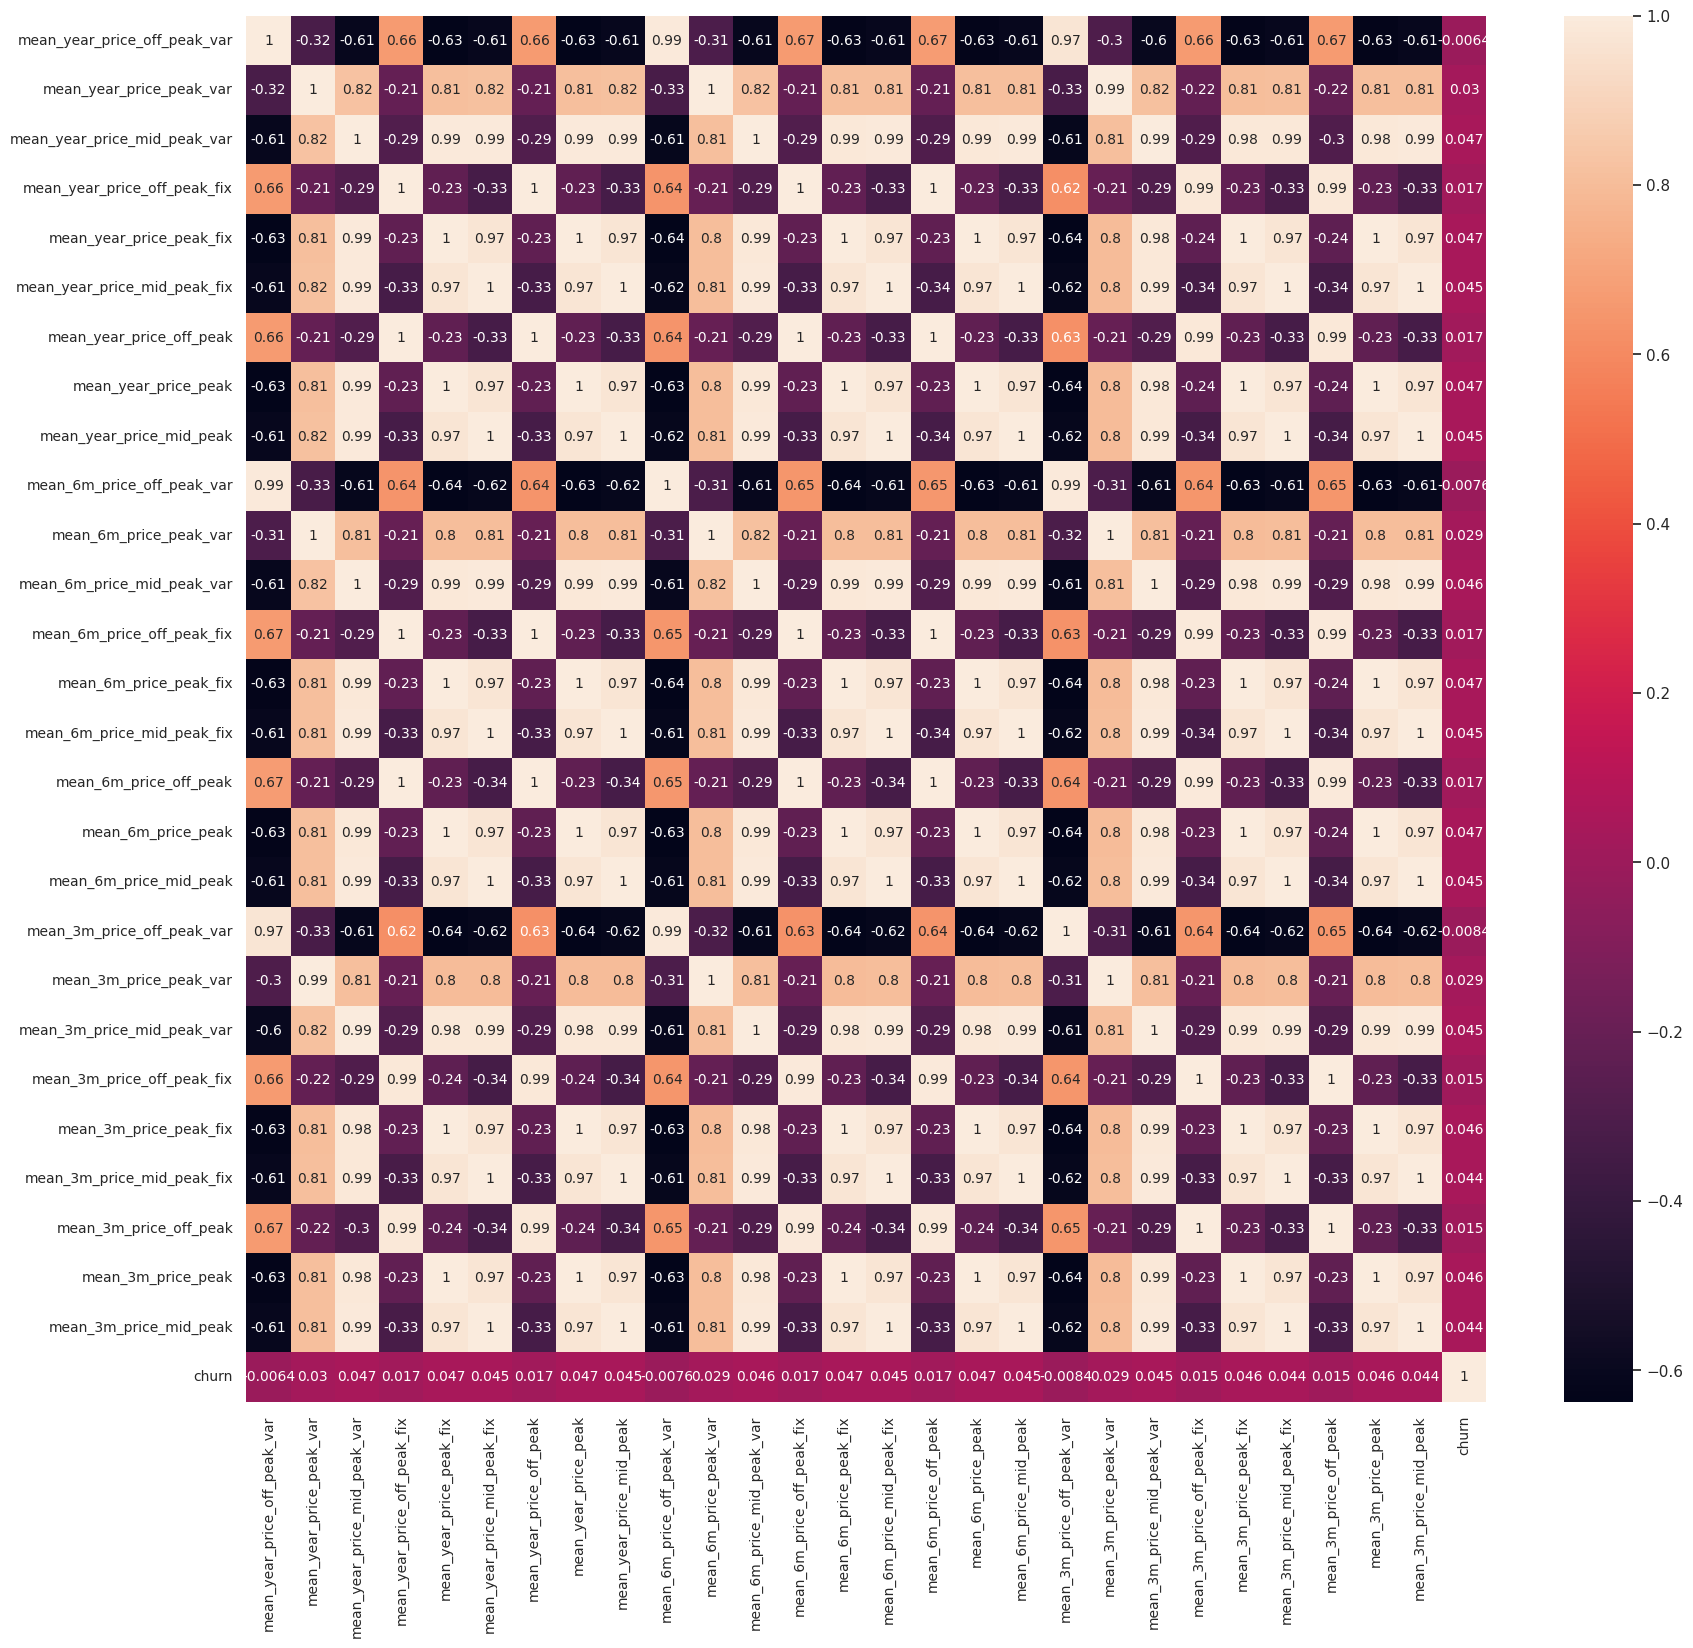

In [102]:
import numpy as np
# Exclude non-numeric and datetime columns
numeric_columns = price_analysis.select_dtypes(include=[np.number])

# Compute correlation matrix
corr = numeric_columns.corr()

# Plot correlation heatmap
plt.figure(figsize=(20, 18))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, annot_kws={'size': 10})

# Set axis ticks size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

In [103]:
merged_data = pd.merge(client_df.drop(columns=['churn']), price_analysis, on='id')

In [104]:
merged_data.to_csv('CustomerChurn/clean_data_after_eda.csv')

In [106]:
df = pd.read_csv('CustomerChurn/clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [107]:
df.head()

Unnamed: 0                                id  \
0           0  24011ae4ebbe3035111d65fa7c15bc57   
1           1  d29c2c54acc38ff3c0614d0a653813dd   
2           2  764c75f661154dac3a6c254cd082ea7d   
3           3  bba03439a292a1e166f80264c16191cb   
4           4  149d57cf92fc41cf94415803a877cb4b   

                      channel_sales  cons_12m  cons_gas_12m  cons_last_month  \
0  foosdfpfkusacimwkcsosbicdxkicaua         0         54946                0   
1                           MISSING      4660             0                0   
2  foosdfpfkusacimwkcsosbicdxkicaua       544             0                0   
3  lmkebamcaaclubfxadlmueccxoimlema      1584             0                0   
4                           MISSING      4425             0              526   

  date_activ   date_end date_modif_prod date_renewal  ...  \
0 2013-06-15 2016-06-15      2015-11-01   2015-06-23  ...   
1 2009-08-21 2016-08-30      2009-08-21   2015-08-31  ...   
2 2010-04-16 2016-04-16      2010-04-16   2015-04-17  ...   
3 2010-03-30 2016-03-30      2010-03-30   2015-03-31  ...   
4 2010-01-13 2016-03-07      2010-01-13   2015-03-09  ...   

   mean_3m_price_off_peak_var  mean_3m_price_peak_var  \
0                    0.131756                0.092638   
1                    0.147600                0.000000   
2                    0.167798                0.088409   
3                    0.148586                0.000000   
4                    0.119906                0.101673   

   mean_3m_price_mid_peak_var  mean_3m_price_off_peak_fix  \
0                    0.036909                   42.497907   
1                    0.000000                   44.444710   
2                    0.000000                   44.444710   
3                    0.000000                   44.444710   
4                    0.073719                   40.728885   

   mean_3m_price_peak_fix  mean_3m_price_mid_peak_fix  mean_3m_price_off_peak  \
0               12.218665                    8.145777               42.629663   
1                0.000000                    0.000000               44.592310   
2                0.000000                    0.000000               44.612508   
3                0.000000                    0.000000               44.593296   
4               24.437330                   16.291555               40.848791   

  mean_3m_price_peak  mean_3m_price_mid_peak  churn  
0          12.311304                8.182687      1  
1           0.000000                0.000000      0  
2           0.088409                0.000000      0  
3           0.000000                0.000000      0  
4          24.539003               16.365274      0  

[5 rows x 57 columns]

In [108]:

price_df["price_date"] = pd.to_datetime(price_df["price_date"],
                                        format='%Y-%m-%d')
price_df.head()

id price_date  price_off_peak_var  \
0  038af19179925da21a25619c5a24b745 2015-01-01            0.151367   
1  038af19179925da21a25619c5a24b745 2015-02-01            0.151367   
2  038af19179925da21a25619c5a24b745 2015-03-01            0.151367   
3  038af19179925da21a25619c5a24b745 2015-04-01            0.149626   
4  038af19179925da21a25619c5a24b745 2015-05-01            0.149626   

   price_peak_var  price_mid_peak_var  price_off_peak_fix  price_peak_fix  \
0             0.0                 0.0           44.266931             0.0   
1             0.0                 0.0           44.266931             0.0   
2             0.0                 0.0           44.266931             0.0   
3             0.0                 0.0           44.266931             0.0   
4             0.0                 0.0           44.266931             0.0   

   price_mid_peak_fix  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0

In [109]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

id  offpeak_diff_dec_january_energy  \
0  0002203ffbb812588b632b9e628cc38d                        -0.006192   
1  0004351ebdd665e6ee664792efc4fd13                        -0.004104   
2  0010bcc39e42b3c2131ed2ce55246e3c                         0.050443   
3  0010ee3855fdea87602a5b7aba8e42de                        -0.010018   
4  00114d74e963e47177db89bc70108537                        -0.003994   

   offpeak_diff_dec_january_power  
0                        0.162916  
1                        0.177779  
2                        1.500000  
3                        0.162916  
4                       -0.000001

In [110]:
df = pd.merge(df, diff, on='id')
df.head()

Unnamed: 0                                id  \
0           0  24011ae4ebbe3035111d65fa7c15bc57   
1           1  d29c2c54acc38ff3c0614d0a653813dd   
2           2  764c75f661154dac3a6c254cd082ea7d   
3           3  bba03439a292a1e166f80264c16191cb   
4           4  149d57cf92fc41cf94415803a877cb4b   

                      channel_sales  cons_12m  cons_gas_12m  cons_last_month  \
0  foosdfpfkusacimwkcsosbicdxkicaua         0         54946                0   
1                           MISSING      4660             0                0   
2  foosdfpfkusacimwkcsosbicdxkicaua       544             0                0   
3  lmkebamcaaclubfxadlmueccxoimlema      1584             0                0   
4                           MISSING      4425             0              526   

  date_activ   date_end date_modif_prod date_renewal  ...  \
0 2013-06-15 2016-06-15      2015-11-01   2015-06-23  ...   
1 2009-08-21 2016-08-30      2009-08-21   2015-08-31  ...   
2 2010-04-16 2016-04-16      2010-04-16   2015-04-17  ...   
3 2010-03-30 2016-03-30      2010-03-30   2015-03-31  ...   
4 2010-01-13 2016-03-07      2010-01-13   2015-03-09  ...   

   mean_3m_price_mid_peak_var  mean_3m_price_off_peak_fix  \
0                    0.036909                   42.497907   
1                    0.000000                   44.444710   
2                    0.000000                   44.444710   
3                    0.000000                   44.444710   
4                    0.073719                   40.728885   

   mean_3m_price_peak_fix  mean_3m_price_mid_peak_fix  mean_3m_price_off_peak  \
0               12.218665                    8.145777               42.629663   
1                0.000000                    0.000000               44.592310   
2                0.000000                    0.000000               44.612508   
3                0.000000                    0.000000               44.593296   
4               24.437330                   16.291555               40.848791   

   mean_3m_price_peak  mean_3m_price_mid_peak churn  \
0           12.311304                8.182687     1   
1            0.000000                0.000000     0   
2            0.088409                0.000000     0   
3            0.000000                0.000000     0   
4           24.539003               16.365274     0   

   offpeak_diff_dec_january_energy  offpeak_diff_dec_january_power  
0                         0.020057                        3.700961  
1                        -0.003767                        0.177779  
2                        -0.004670                        0.177779  
3                        -0.004547                        0.177779  
4                        -0.006192                        0.162916  

[5 rows x 59 columns]

In [111]:
mean_prices = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean',
    'price_peak_var': 'mean',
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'
}).reset_index()

In [112]:
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']

In [113]:
columns = [
    'id',
    'off_peak_peak_var_mean_diff',
    'peak_mid_peak_var_mean_diff',
    'off_peak_mid_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff',
    'peak_mid_peak_fix_mean_diff',
    'off_peak_mid_peak_fix_mean_diff'
]
df = pd.merge(df, mean_prices[columns], on='id')
df.head()

Unnamed: 0                                id  \
0           0  24011ae4ebbe3035111d65fa7c15bc57   
1           1  d29c2c54acc38ff3c0614d0a653813dd   
2           2  764c75f661154dac3a6c254cd082ea7d   
3           3  bba03439a292a1e166f80264c16191cb   
4           4  149d57cf92fc41cf94415803a877cb4b   

                      channel_sales  cons_12m  cons_gas_12m  cons_last_month  \
0  foosdfpfkusacimwkcsosbicdxkicaua         0         54946                0   
1                           MISSING      4660             0                0   
2  foosdfpfkusacimwkcsosbicdxkicaua       544             0                0   
3  lmkebamcaaclubfxadlmueccxoimlema      1584             0                0   
4                           MISSING      4425             0              526   

  date_activ   date_end date_modif_prod date_renewal  ...  \
0 2013-06-15 2016-06-15      2015-11-01   2015-06-23  ...   
1 2009-08-21 2016-08-30      2009-08-21   2015-08-31  ...   
2 2010-04-16 2016-04-16      2010-04-16   2015-04-17  ...   
3 2010-03-30 2016-03-30      2010-03-30   2015-03-31  ...   
4 2010-01-13 2016-03-07      2010-01-13   2015-03-09  ...   

   mean_3m_price_mid_peak  churn  offpeak_diff_dec_january_energy  \
0                8.182687      1                         0.020057   
1                0.000000      0                        -0.003767   
2                0.000000      0                        -0.004670   
3                0.000000      0                        -0.004547   
4               16.365274      0                        -0.006192   

   offpeak_diff_dec_january_power  off_peak_peak_var_mean_diff  \
0                        3.700961                     0.024038   
1                        0.177779                     0.142485   
2                        0.177779                     0.082090   
3                        0.177779                     0.151210   
4                        0.162916                     0.020536   

   peak_mid_peak_var_mean_diff  off_peak_mid_peak_var_mean_diff  \
0                     0.034219                         0.058257   
1                     0.007124                         0.149609   
2                     0.088421                         0.170512   
3                     0.000000                         0.151210   
4                     0.030773                         0.051309   

  off_peak_peak_fix_mean_diff  peak_mid_peak_fix_mean_diff  \
0                   18.590255                     7.450670   
1                   44.311375                     0.000000   
2                   44.385450                     0.000000   
3                   44.400265                     0.000000   
4                   16.275263                     8.137629   

   off_peak_mid_peak_fix_mean_diff  
0                        26.040925  
1                        44.311375  
2                        44.385450  
3                        44.400265  
4                        24.412893  

[5 rows x 65 columns]

In [114]:
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean',
    'price_peak_var': 'mean',
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'
}).reset_index()

In [115]:
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

In [116]:
# Calculate the maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

In [117]:
columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()

Unnamed: 0                                id  \
0           0  24011ae4ebbe3035111d65fa7c15bc57   
1           1  d29c2c54acc38ff3c0614d0a653813dd   
2           2  764c75f661154dac3a6c254cd082ea7d   
3           3  bba03439a292a1e166f80264c16191cb   
4           4  149d57cf92fc41cf94415803a877cb4b   

                      channel_sales  cons_12m  cons_gas_12m  cons_last_month  \
0  foosdfpfkusacimwkcsosbicdxkicaua         0         54946                0   
1                           MISSING      4660             0                0   
2  foosdfpfkusacimwkcsosbicdxkicaua       544             0                0   
3  lmkebamcaaclubfxadlmueccxoimlema      1584             0                0   
4                           MISSING      4425             0              526   

  date_activ   date_end date_modif_prod date_renewal  ...  \
0 2013-06-15 2016-06-15      2015-11-01   2015-06-23  ...   
1 2009-08-21 2016-08-30      2009-08-21   2015-08-31  ...   
2 2010-04-16 2016-04-16      2010-04-16   2015-04-17  ...   
3 2010-03-30 2016-03-30      2010-03-30   2015-03-31  ...   
4 2010-01-13 2016-03-07      2010-01-13   2015-03-09  ...   

   off_peak_mid_peak_var_mean_diff  off_peak_peak_fix_mean_diff  \
0                         0.058257                    18.590255   
1                         0.149609                    44.311375   
2                         0.170512                    44.385450   
3                         0.151210                    44.400265   
4                         0.051309                    16.275263   

   peak_mid_peak_fix_mean_diff  off_peak_mid_peak_fix_mean_diff  \
0                     7.450670                        26.040925   
1                     0.000000                        44.311375   
2                     0.000000                        44.385450   
3                     0.000000                        44.400265   
4                     8.137629                        24.412893   

   off_peak_peak_var_max_monthly_diff  peak_mid_peak_var_max_monthly_diff  \
0                            0.060550                            0.085483   
1                            0.151367                            0.085483   
2                            0.084587                            0.089162   
3                            0.153133                            0.000000   
4                            0.022225                            0.033743   

   off_peak_mid_peak_var_max_monthly_diff off_peak_peak_fix_max_monthly_diff  \
0                                0.146033                          44.266930   
1                                0.151367                          44.444710   
2                                0.172468                          44.444710   
3                                0.153133                          44.444710   
4                                0.055866                          16.291555   

   peak_mid_peak_fix_max_monthly_diff  off_peak_mid_peak_fix_max_monthly_diff  
0                            8.145775                                44.26693  
1                            0.000000                                44.44471  
2                            0.000000                                44.44471  
3                            0.000000                                44.44471  
4                            8.145775                                24.43733  

[5 rows x 71 columns]

In [118]:
df['tenure'] = (df['date_end'] - df['date_activ']).dt.days / 365
df['tenure'] = df['tenure'].astype(int)

In [119]:
df.groupby(['tenure']).agg({'churn': 'mean'}).sort_values(by='churn', ascending=False)

churn
tenure          
2       0.176471
3       0.143987
4       0.127473
13      0.095238
5       0.091999
12      0.083333
7       0.075472
6       0.075407
11      0.059783
8       0.047244
10      0.045455
9       0.012500

In [120]:
def convert_months(reference_date, df, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = reference_date - df[column]
    months = (time_delta / np.timedelta64(1, 'M')).astype(int)
    return months

In [121]:
def convert_months(reference_date, df, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = reference_date - df[column]
    months = time_delta.dt.days / 30.44  # Average days in a month
    return months.astype(int)

# Assuming df['date_activ'], df['date_end'], etc., are in datetime format
reference_date = datetime(2016, 1, 1)

df['months_activ'] = convert_months(reference_date, df, 'date_activ')
df['months_to_end'] = -convert_months(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')

In [122]:
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df = df.drop(columns=remove)
df.head()

Unnamed: 0                                id  \
0           0  24011ae4ebbe3035111d65fa7c15bc57   
1           1  d29c2c54acc38ff3c0614d0a653813dd   
2           2  764c75f661154dac3a6c254cd082ea7d   
3           3  bba03439a292a1e166f80264c16191cb   
4           4  149d57cf92fc41cf94415803a877cb4b   

                      channel_sales  cons_12m  cons_gas_12m  cons_last_month  \
0  foosdfpfkusacimwkcsosbicdxkicaua         0         54946                0   
1                           MISSING      4660             0                0   
2  foosdfpfkusacimwkcsosbicdxkicaua       544             0                0   
3  lmkebamcaaclubfxadlmueccxoimlema      1584             0                0   
4                           MISSING      4425             0              526   

   forecast_cons_12m  forecast_cons_year  forecast_discount_energy  \
0               0.00                   0                       0.0   
1             189.95                   0                       0.0   
2              47.96                   0                       0.0   
3             240.04                   0                       0.0   
4             445.75                 526                       0.0   

   forecast_meter_rent_12m  ...  peak_mid_peak_var_max_monthly_diff  \
0                     1.78  ...                            0.085483   
1                    16.27  ...                            0.085483   
2                    38.72  ...                            0.089162   
3                    19.83  ...                            0.000000   
4                   131.73  ...                            0.033743   

   off_peak_mid_peak_var_max_monthly_diff  off_peak_peak_fix_max_monthly_diff  \
0                                0.146033                           44.266930   
1                                0.151367                           44.444710   
2                                0.172468                           44.444710   
3                                0.153133                           44.444710   
4                                0.055866                           16.291555   

  peak_mid_peak_fix_max_monthly_diff  off_peak_mid_peak_fix_max_monthly_diff  \
0                           8.145775                                44.26693   
1                           0.000000                                44.44471   
2                           0.000000                                44.44471   
3                           0.000000                                44.44471   
4                           8.145775                                24.43733   

   tenure  months_activ  months_to_end  months_modif_prod  months_renewal  
0       3            30              5                  2               6  
1       7            76              7                 76               4  
2       6            68              3                 68               8  
3       6            69              2                 69               9  
4       6            71              2                 71               9  

[5 rows x 72 columns]

In [123]:
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])
df.groupby(['has_gas']).agg({'churn': 'mean'})

churn
has_gas          
0        0.100544
1        0.081887

In [124]:
# Transform into categorical type
df['channel_sales'] = df['channel_sales'].astype('category')

# Let's see how many categories are within this column
df['channel_sales'].value_counts()

channel_sales
foosdfpfkusacimwkcsosbicdxkicaua    6753
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: count, dtype: int64

In [125]:
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel')
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()

Unnamed: 0                                id  cons_12m  cons_gas_12m  \
0           0  24011ae4ebbe3035111d65fa7c15bc57         0         54946   
1           1  d29c2c54acc38ff3c0614d0a653813dd      4660             0   
2           2  764c75f661154dac3a6c254cd082ea7d       544             0   
3           3  bba03439a292a1e166f80264c16191cb      1584             0   
4           4  149d57cf92fc41cf94415803a877cb4b      4425             0   

   cons_last_month  forecast_cons_12m  forecast_cons_year  \
0                0               0.00                   0   
1                0             189.95                   0   
2                0              47.96                   0   
3                0             240.04                   0   
4              526             445.75                 526   

   forecast_discount_energy  forecast_meter_rent_12m  \
0                       0.0                     1.78   
1                       0.0                    16.27   
2                       0.0                    38.72   
3                       0.0                    19.83   
4                       0.0                   131.73   

   forecast_price_energy_off_peak  ...  tenure  months_activ  months_to_end  \
0                        0.114481  ...       3            30              5   
1                        0.145711  ...       7            76              7   
2                        0.165794  ...       6            68              3   
3                        0.146694  ...       6            69              2   
4                        0.116900  ...       6            71              2   

   months_modif_prod  months_renewal  channel_MISSING  \
0                  2               6            False   
1                 76               4             True   
2                 68               8            False   
3                 69               9            False   
4                 71               9             True   

   channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                      True   
1                                     False   
2                                      True   
3                                     False   
4                                     False   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                     False   
1                                     False   
2                                     False   
3                                      True   
4                                     False   

  channel_usilxuppasemubllopkaafesmlibmsdf  
0                                    False  
1                                    False  
2                                    False  
3                                    False  
4                                    False  

[5 rows x 76 columns]

In [126]:
# Transform into categorical type
df['origin_up'] = df['origin_up'].astype('category')

# Let's see how many categories are within this column
df['origin_up'].value_counts()

origin_up
lxidpiddsbxsbosboudacockeimpuepw    7096
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: count, dtype: int64

In [127]:
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
df = df.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

Unnamed: 0                                id  cons_12m  cons_gas_12m  \
0           0  24011ae4ebbe3035111d65fa7c15bc57         0         54946   
1           1  d29c2c54acc38ff3c0614d0a653813dd      4660             0   
2           2  764c75f661154dac3a6c254cd082ea7d       544             0   
3           3  bba03439a292a1e166f80264c16191cb      1584             0   
4           4  149d57cf92fc41cf94415803a877cb4b      4425             0   

   cons_last_month  forecast_cons_12m  forecast_cons_year  \
0                0               0.00                   0   
1                0             189.95                   0   
2                0              47.96                   0   
3                0             240.04                   0   
4              526             445.75                 526   

   forecast_discount_energy  forecast_meter_rent_12m  \
0                       0.0                     1.78   
1                       0.0                    16.27   
2                       0.0                    38.72   
3                       0.0                    19.83   
4                       0.0                   131.73   

   forecast_price_energy_off_peak  ...  months_modif_prod  months_renewal  \
0                        0.114481  ...                  2               6   
1                        0.145711  ...                 76               4   
2                        0.165794  ...                 68               8   
3                        0.146694  ...                 69               9   
4                        0.116900  ...                 71               9   

   channel_MISSING  channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0            False                                     False   
1             True                                     False   
2            False                                     False   
3            False                                     False   
4             True                                     False   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                      True   
1                                     False   
2                                      True   
3                                     False   
4                                     False   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                     False   
1                                     False   
2                                     False   
3                                      True   
4                                     False   

   channel_usilxuppasemubllopkaafesmlibmsdf  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws  \
0                                       False   
1                                        True   
2                                        True   
3                                        True   
4                                        True   

   origin_up_ldkssxwpmemidmecebumciepifcamkci  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   origin_up_lxidpiddsbxsbosboudacockeimpuepw  
0                                        True  
1                                       False  
2                                       False  
3                                       False  
4                                       False  

[5 rows x 78 columns]

In [128]:
skewed = [
    'cons_12m',
    'cons_gas_12m',
    'cons_last_month',
    'forecast_cons_12m',
    'forecast_cons_year',
    'forecast_discount_energy',
    'forecast_meter_rent_12m',
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak',
    'forecast_price_pow_off_peak'
]

df[skewed].describe()

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  1.460500e+04  1.460500e+04     14605.000000       14605.000000   
mean   1.592303e+05  2.809108e+04     16091.371448        1868.638618   
std    5.734836e+05  1.629786e+05     64366.262314        2387.651549   
min    0.000000e+00  0.000000e+00         0.000000           0.000000   
25%    5.674000e+03  0.000000e+00         0.000000         494.980000   
50%    1.411600e+04  0.000000e+00       793.000000        1112.610000   
75%    4.076400e+04  0.000000e+00      3383.000000        2402.270000   
max    6.207104e+06  4.154590e+06    771203.000000       82902.830000   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count        14605.000000              14605.000000             14605.000000   
mean          1399.858747                  0.966450                63.090448   
std           3247.876793                  5.108355                66.166636   
min              0.000000                  0.000000                 0.000000   
25%              0.000000                  0.000000                16.180000   
50%            314.000000                  0.000000                18.800000   
75%           1746.000000                  0.000000               131.030000   
max         175375.000000                 30.000000               599.310000   

       forecast_price_energy_off_peak  forecast_price_energy_peak  \
count                    14605.000000                14605.000000   
mean                         0.137282                    0.050488   
std                          0.024623                    0.049037   
min                          0.000000                    0.000000   
25%                          0.116340                    0.000000   
50%                          0.143166                    0.084138   
75%                          0.146348                    0.098837   
max                          0.273963                    0.195975   

       forecast_price_pow_off_peak  
count                 14605.000000  
mean                     43.130085  
std                       4.486140  
min                       0.000000  
25%                      40.606701  
50%                      44.311378  
75%                      44.311378  
max                      59.266378

In [129]:
# Apply log10 transformation
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)

In [130]:
df[skewed].describe()

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  14605.000000  14605.000000     14605.000000       14605.000000   
mean       4.223945      0.778978         2.264801           2.962162   
std        0.884545      1.716828         1.769266           0.683612   
min        0.000000      0.000000         0.000000           0.000000   
25%        3.753966      0.000000         0.000000           2.695464   
50%        4.149742      0.000000         2.899821           3.046733   
75%        4.610287      0.000000         3.529430           3.380803   
max        6.792889      6.618528         5.887169           4.918575   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count        14605.000000              14605.000000             14605.000000   
mean             1.784733                  0.966450                 1.517233   
std              1.584972                  5.108355                 0.571489   
min              0.000000                  0.000000                 0.000000   
25%              0.000000                  0.000000                 1.235023   
50%              2.498311                  0.000000                 1.296665   
75%              3.242293                  0.000000                 2.120673   
max              5.243970                 30.000000                 2.778376   

       forecast_price_energy_off_peak  forecast_price_energy_peak  \
count                    14605.000000                14605.000000   
mean                         0.137282                    0.050488   
std                          0.024623                    0.049037   
min                          0.000000                    0.000000   
25%                          0.116340                    0.000000   
50%                          0.143166                    0.084138   
75%                          0.146348                    0.098837   
max                          0.273963                    0.195975   

       forecast_price_pow_off_peak  
count                 14605.000000  
mean                     43.130085  
std                       4.486140  
min                       0.000000  
25%                      40.606701  
50%                      44.311378  
75%                      44.311378  
max                      59.266378

<ipython-input-131-f63759cfd0e3>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
<ipython-input-131-f63759cfd0e3>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
<ipython-input-131-f63759cfd0e3>:5

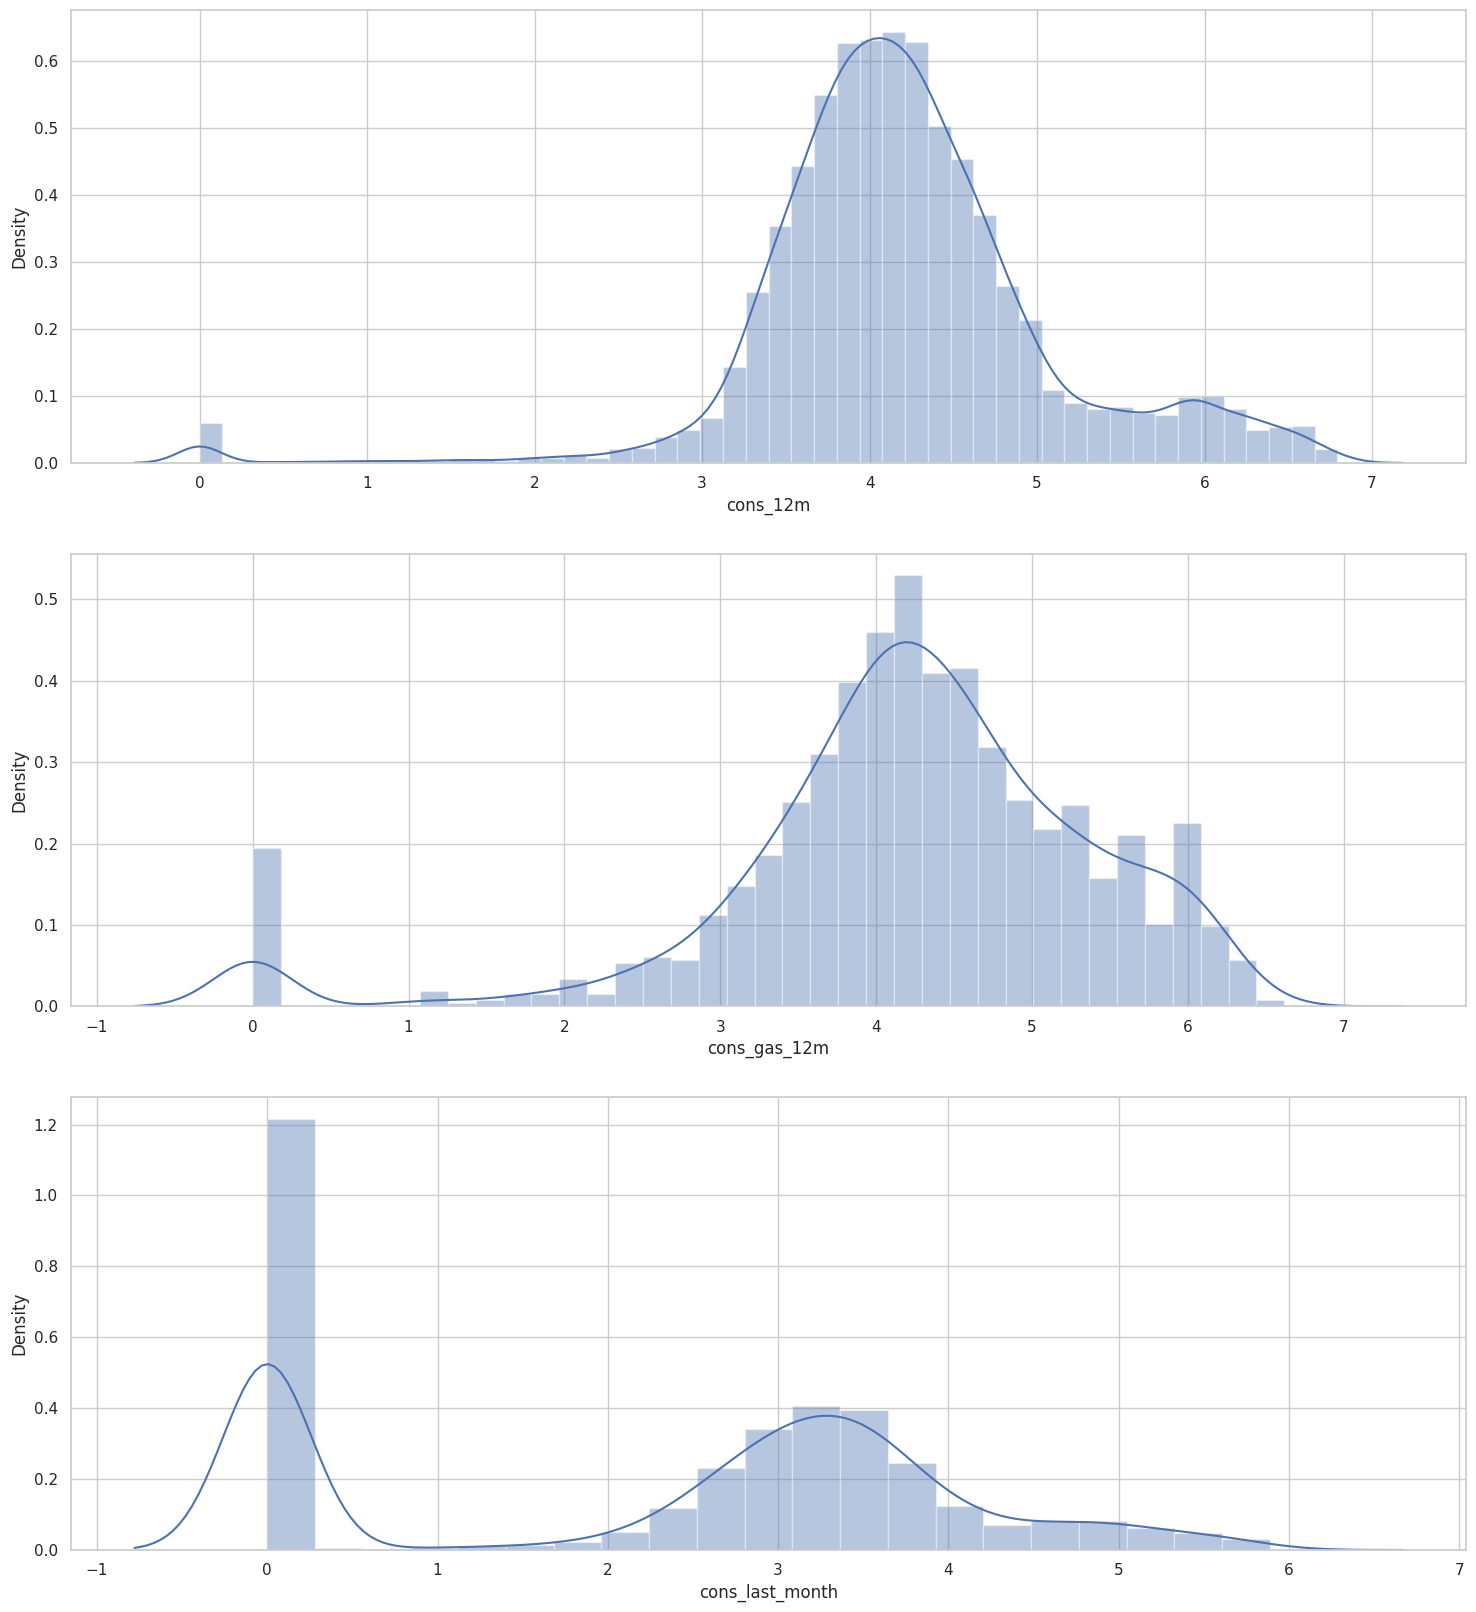

In [131]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))
# Plot histograms
sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((df["cons_last_month"].dropna()), ax=axs[2])
plt.show()

In [132]:
# Drop the 'id' column in-place
df.drop('id', axis=1, inplace=True)

In [133]:
# Convert object columns to datetime
df['price_date_x'] = pd.to_datetime(df['price_date_x'])
df['price_date_y'] = pd.to_datetime(df['price_date_y'])
df['price_date'] = pd.to_datetime(df['price_date'])

In [134]:
correlation = df.corr()

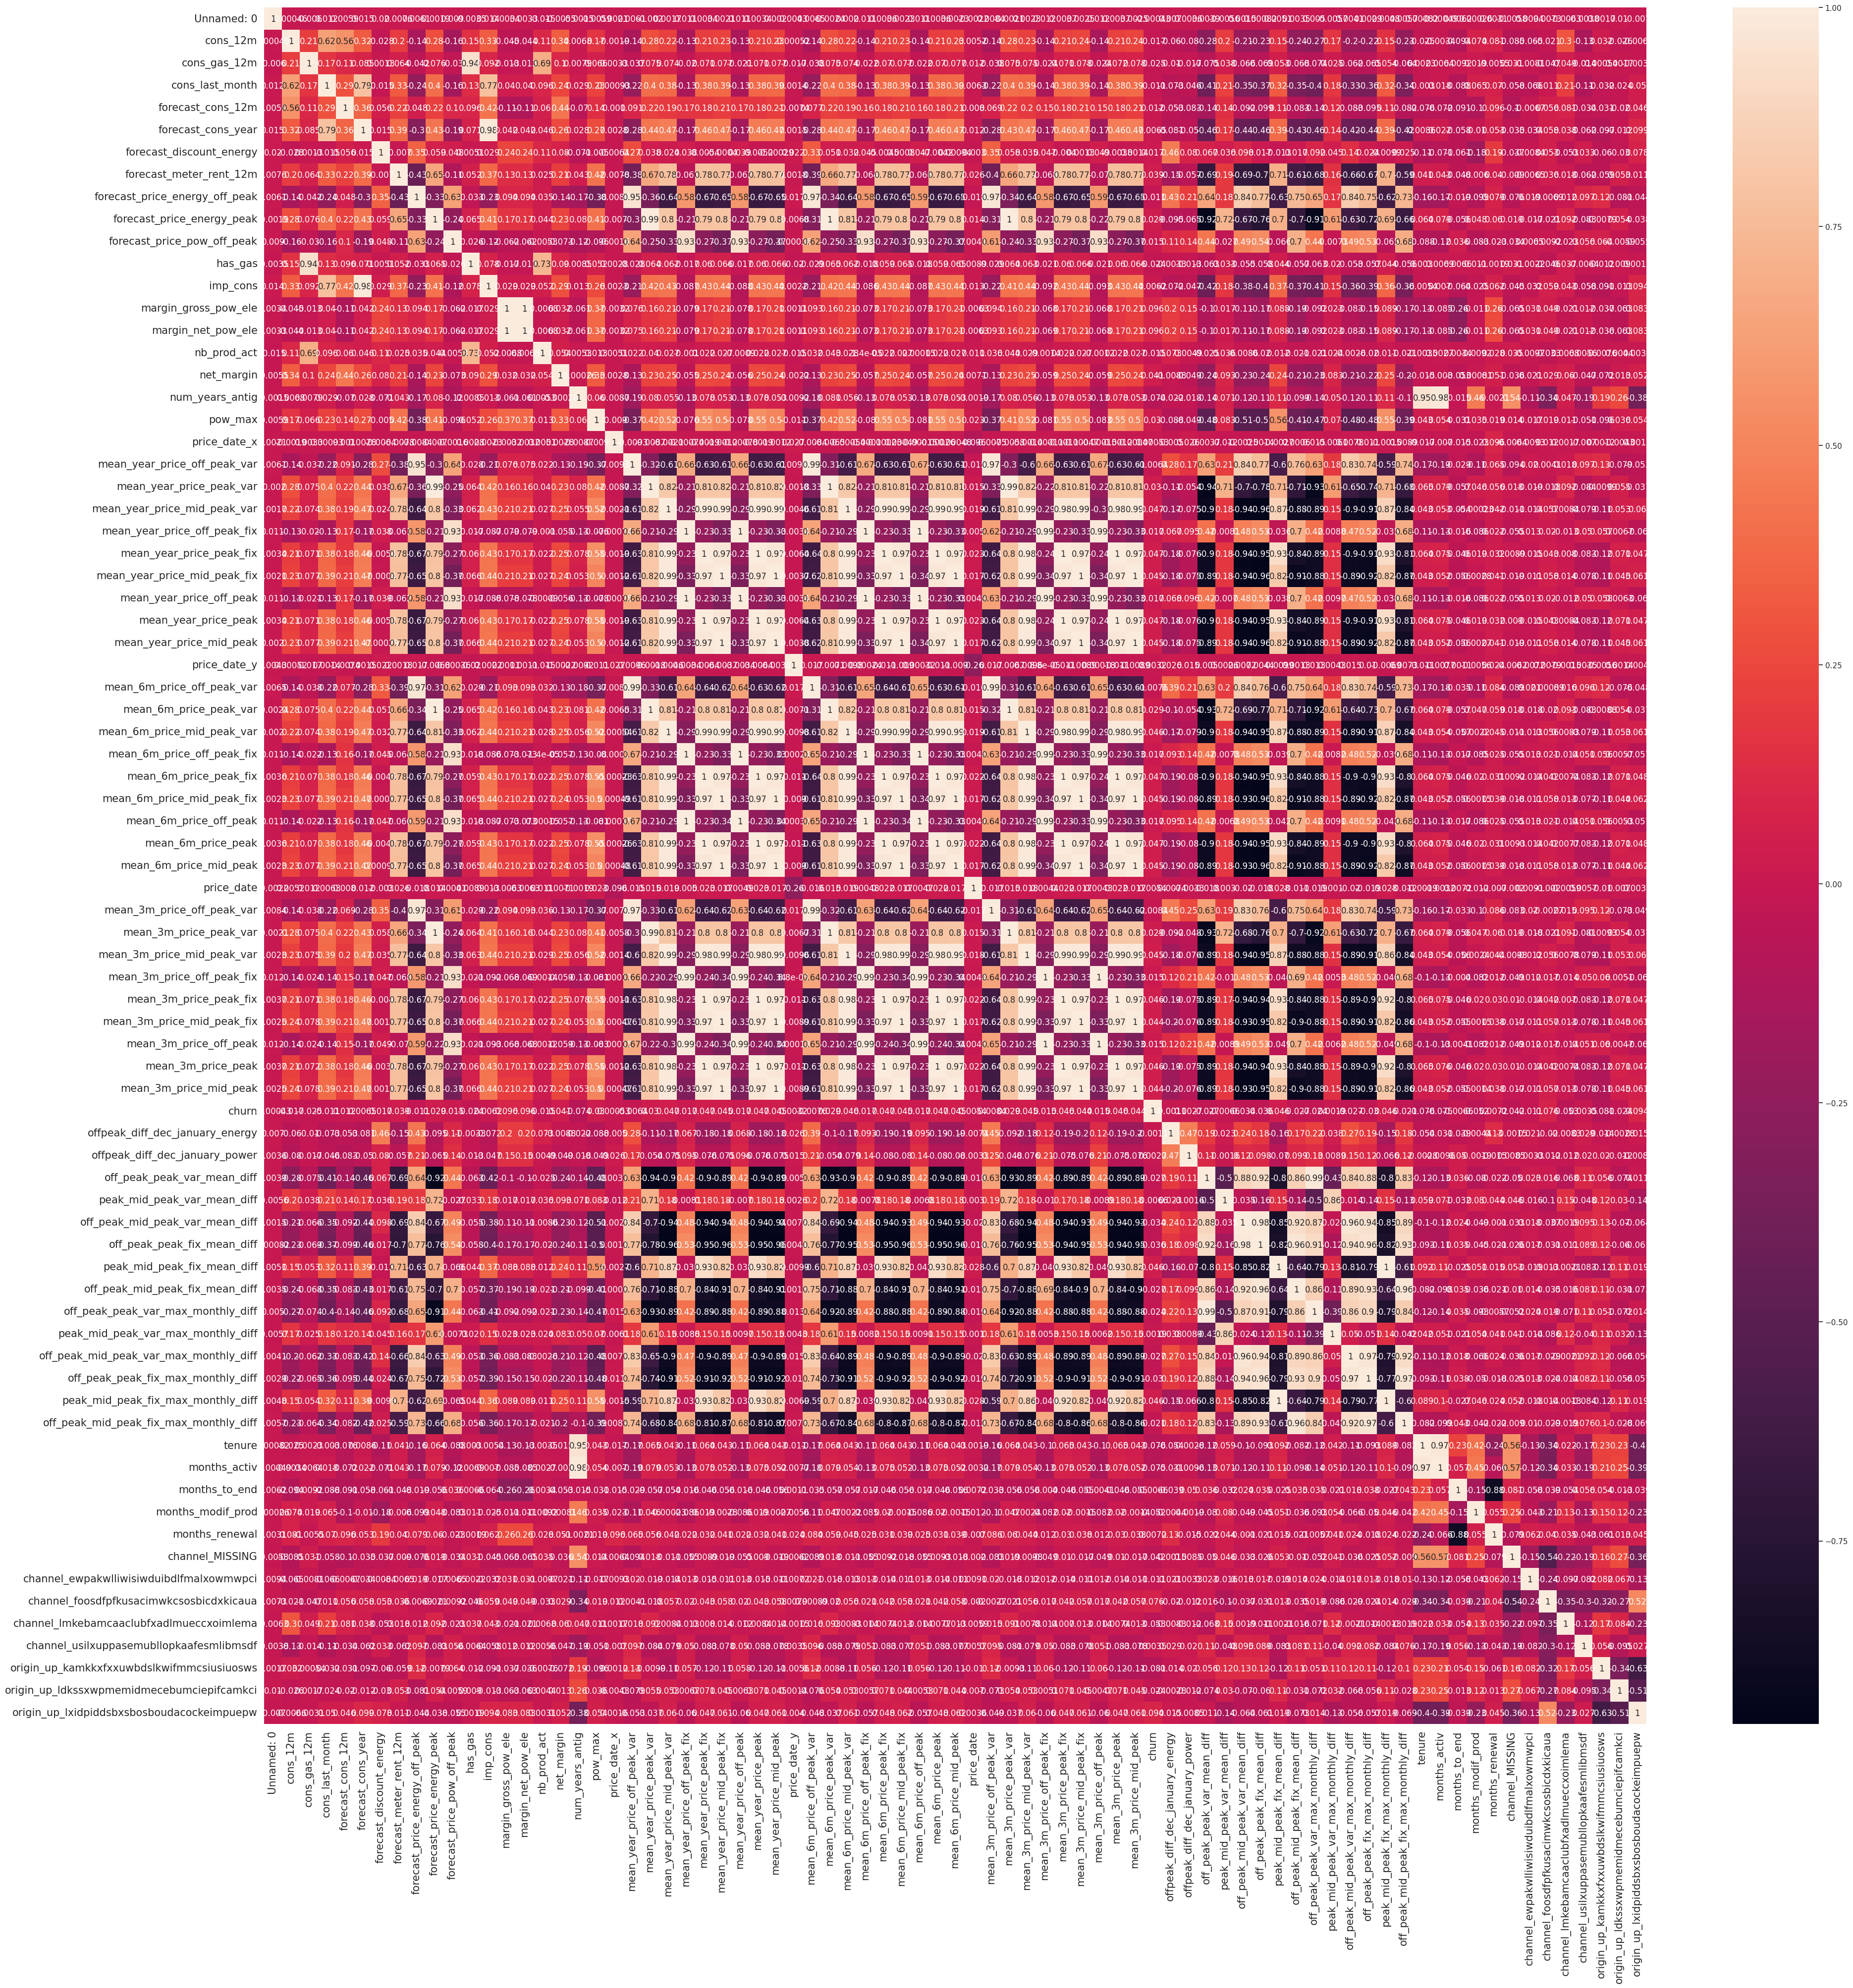

In [135]:
# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation,
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values,
    annot=True,
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [136]:
# Make a copy of our data
train_df = df.copy()

# Separate target variable from independent variables
y = df['churn']
X = df.drop(columns=['churn', 'price_date_x', 'price_date_y', 'price_date'])

print(X.shape)
print(y.shape)

(14605, 73)
(14605,)


In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10953, 73)
(10953,)
(3652, 73)
(3652,)


In [138]:
model = RandomForestClassifier(
    n_estimators=1000
)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [139]:
predictions = model.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()

In [140]:
y_test.value_counts()
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Accuracy: {metrics.accuracy_score(y_test, predictions)}")
print(f"Precision: {metrics.precision_score(y_test, predictions)}")
print(f"Recall: {metrics.recall_score(y_test, predictions)}")

True positives: 17
False positives: 0
True negatives: 3279
False negatives: 356

Accuracy: 0.9025191675794085
Precision: 1.0
Recall: 0.045576407506702415


In [141]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

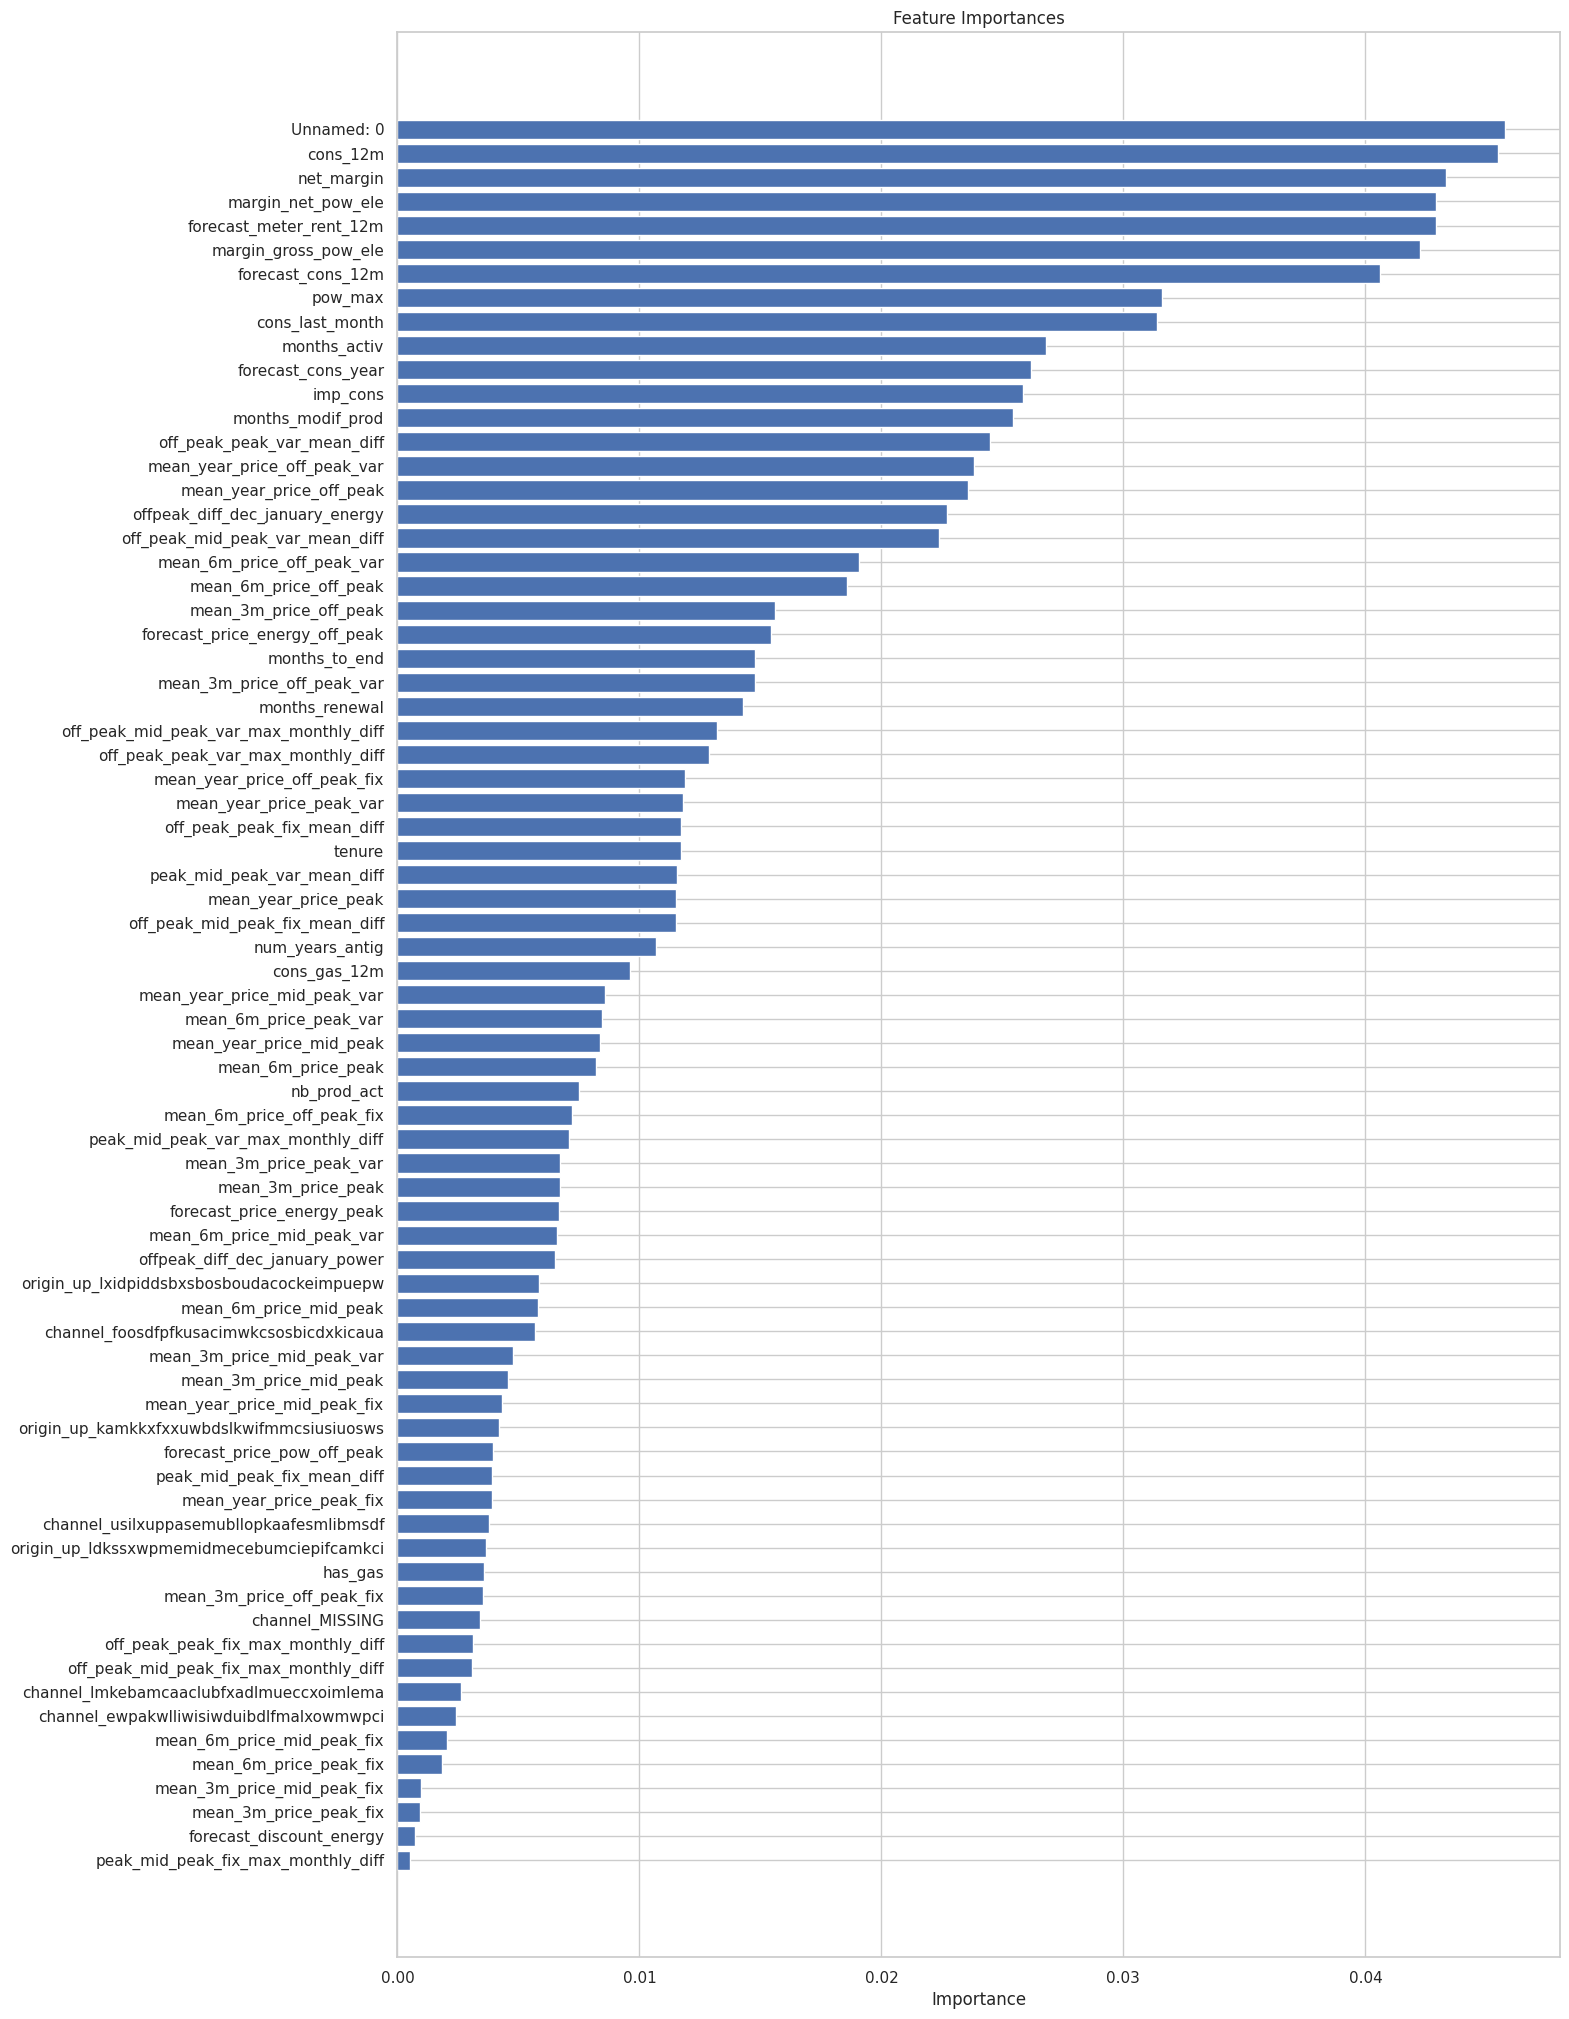

In [142]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

In [143]:
proba_predictions = model.predict_proba(X_test)
probabilities = proba_predictions[:, 1]

In [144]:
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)

In [145]:
X_test['churn'] = predictions.tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.to_csv('CustomerChurn/out_of_sample_data_with_predictions.csv')

In [146]:
#### CODE SOURCE : https://www.kaggle.com/code/mirajahmedlearns/bcg-customer-churn-prediction